## Import Stuff

In [1]:
import sqlite3
import pandas as pd
from pathlib import Path

DB_PATH = 'chembl_36/chembl_36_sqlite/chembl_36.db'

print(f"  Size: {Path(DB_PATH).stat().st_size / (1024**3):.1f} GB")

conn = sqlite3.connect(DB_PATH)

  Size: 27.7 GB


In [2]:
query = """

SELECT DISTINCT
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    cs.canonical_smiles as smile
FROM molecule_dictionary md
JOIN compound_structures cs ON md.molregno = cs.molregno
WHERE md.max_phase = 4
  AND md.molecule_type = 'Small molecule'
  AND cs.canonical_smiles IS NOT NULL
ORDER BY md.chembl_id;

"""

approved_drugs = pd.read_sql(query, conn)
print(f"Found {len(approved_drugs)} approved small molecule drugs")
print(approved_drugs.head().to_string(index=False))

Found 3127 approved small molecule drugs
 drug_internal_id      drug_id             drug_name                                          smile
           111185   CHEMBL1000            CETIRIZINE    O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
           165474 CHEMBL100116           PENTAZOCINE             CC(C)=CCN1CCC2(C)c3cc(O)ccc3CC1C2C
           111482   CHEMBL1002        LEVOSALBUTAMOL              CC(C)(C)NC[C@H](O)c1ccc(O)c(CO)c1
           111491   CHEMBL1003 CLAVULANATE POTASSIUM O=C([O-])[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21.[K+]
           111498   CHEMBL1004            DOXYLAMINE                 CN(C)CCOC(C)(c1ccccc1)c1ccccn1


In [61]:
second_query = """ -- Drug-Protein interactions with binding strength (NO action_type)
SELECT 
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    
    td.tid as protein_internal_id,
    td.chembl_id as protein_id,
    td.pref_name as protein_name,
    
    -- Binding strength (aggregated from multiple measurements)
    MAX(act.pchembl_value) as pchembl_max,
    ROUND(AVG(act.pchembl_value), 2) as pchembl_avg,
    MIN(act.standard_value) as best_value,
    COUNT(DISTINCT act.activity_id) as num_measurements,
    
    -- Quality
    MAX(ass.confidence_score) as confidence

FROM activities act
JOIN assays ass ON act.assay_id = ass.assay_id
JOIN target_dictionary td ON ass.tid = td.tid
JOIN molecule_dictionary md ON act.molregno = md.molregno

WHERE md.max_phase = 4
  AND td.target_type = 'SINGLE PROTEIN'
  AND td.organism = 'Homo sapiens'
 AND act.pchembl_value >= 5.5
 AND ass.confidence_score >= 8
  
GROUP BY 
    md.molregno, md.chembl_id, md.pref_name,
    td.tid, td.chembl_id, td.pref_name

ORDER BY md.chembl_id, pchembl_max DESC;

"""

drugs_interactions = pd.read_sql(second_query, conn)
print(f"Found {len(drugs_interactions)} drug-protein interactions")
drugs_interactions

Found 11703 drug-protein interactions


,drug_internal_id,drug_id,drug_name,protein_internal_id,protein_id,protein_name,pchembl_max,pchembl_avg,best_value,num_measurements,confidence
0,111185,CHEMBL1000,CETIRIZINE,127,CHEMBL231,Histamine H1 receptor,8.23,7.50,5.89,12,9
1,111185,CHEMBL1000,CETIRIZINE,102,CHEMBL1941,Histamine H2 receptor,5.73,5.73,1851.40,1,8
2,111185,CHEMBL1000,CETIRIZINE,107,CHEMBL224,5-hydroxytryptamine receptor 2A,5.67,5.67,2117.80,1,8
3,165474,CHEMBL100116,PENTAZOCINE,137,CHEMBL237,Kappa-type opioid receptor,8.66,8.06,2.20,3,9
4,165474,CHEMBL100116,PENTAZOCINE,129,CHEMBL233,Mu-type opioid receptor,8.57,7.65,2.70,12,9
...,...,...,...,...,...,...,...,...,...,...,...
11698,110803,CHEMBL998,LORATADINE,11912,CHEMBL3401,Nuclear receptor subfamily 1 group I member 2,5.52,5.52,3000.00,1,9
11699,110803,CHEMBL998,LORATADINE,11180,CHEMBL2047,Bile acid receptor,5.51,5.51,3070.00,1,9
11700,164035,CHEMBL99946,LEVOMILNACIPRAN,100,CHEMBL222,Sodium-dependent noradrenaline transporter,7.98,7.59,10.50,3,9
11701,164035,CHEMBL99946,LEVOMILNACIPRAN,121,CHEMBL228,Sodium-dependent serotonin transporter,6.50,6.50,320.00,2,9


In [40]:
unique_proteins = drugs_interactions['protein_id'].nunique()
print(f"Number of unique protein_id in drugs_interactions: {unique_proteins}")

Number of unique protein_id in drugs_interactions: 1156


In [10]:
# drug effect

drug_effects = pd.read_sql("""
-- Drug-Clinical Effect relationships
SELECT 
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    
    di.mesh_id as effect_id,
    di.mesh_heading as effect_name,
    di.efo_id as efo_id,
    di.efo_term as efo_term,
    
    di.max_phase_for_ind as indication_phase,
    
    COUNT(*) as num_references

FROM drug_indication di
JOIN molecule_dictionary md ON di.molregno = md.molregno

WHERE md.max_phase = 4
  AND di.mesh_id IS NOT NULL
    AND di.max_phase_for_ind >= 4.0 

GROUP BY 
    md.molregno, md.chembl_id, md.pref_name,
    di.mesh_id, di.mesh_heading,
    di.efo_id, di.efo_term,
    di.max_phase_for_ind

ORDER BY md.chembl_id, di.max_phase_for_ind DESC;
""", conn)
print(f"Found {len(drug_effects)} drug-clinical effect relationships")


Found 8312 drug-clinical effect relationships


In [11]:
drug_effects

,drug_internal_id,drug_id,drug_name,effect_id,effect_name,efo_id,efo_term,indication_phase,num_references
0,111185,CHEMBL1000,CETIRIZINE,D005132,Eye Manifestations,EFO:0005751,eye allergy,4,1
1,111185,CHEMBL1000,CETIRIZINE,D006967,Hypersensitivity,MONDO:0005271,allergic disease,4,1
2,165474,CHEMBL100116,PENTAZOCINE,D010146,Pain,EFO:0003843,pain,4,1
3,111491,CHEMBL1003,CLAVULANATE POTASSIUM,D007239,Infections,EFO:0000544,infection,4,1
4,111491,CHEMBL1003,CLAVULANATE POTASSIUM,D010033,Otitis Media,EFO:0004992,Otitis media,4,1
...,...,...,...,...,...,...,...,...,...
8307,110803,CHEMBL998,LORATADINE,D006967,Hypersensitivity,MONDO:0005271,allergic disease,4,1
8308,110803,CHEMBL998,LORATADINE,D011537,Pruritus,HP:0000989,Pruritus,4,1
8309,110803,CHEMBL998,LORATADINE,D012221,"Rhinitis, Allergic, Perennial",EFO:1001417,"Rhinitis, Allergic, Perennial",4,1
8310,110803,CHEMBL998,LORATADINE,D014581,Urticaria,EFO:0005531,urticaria,4,1


In [12]:
drug_warnings = pd.read_sql(""" 
-- Drug warnings and adverse effects
SELECT 
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    
    dw.warning_type,
    dw.warning_class,
    dw.warning_description,
    dw.efo_id,
    dw.efo_term,
    dw.warning_year,
    dw.warning_country
    
FROM drug_warning dw
JOIN molecule_dictionary md ON dw.molregno = md.molregno

WHERE md.max_phase = 4

ORDER BY md.chembl_id;
""", conn)

print(f"Found {len(drug_warnings)} drug warnings and adverse effects")


Found 2294 drug warnings and adverse effects


In [17]:
drug_warnings.head(10)

,drug_internal_id,drug_id,drug_name,warning_type,warning_class,warning_description,efo_id,efo_term,warning_year,warning_country
0,12417,CHEMBL101,PHENYLBUTAZONE,Withdrawn,None,severe adverse reactions,EFO:0009658,adverse effect,1984.0,Malaysia; United Arab Emirates; Ethiopia; Jord...
1,12417,CHEMBL101,PHENYLBUTAZONE,Withdrawn,drug misuse,Off-Label Abuse; Hematologic Toxicity,MONDO:0002491,substance abuse,1984.0,Malaysia; United Arab Emirates; Ethiopia; Jord...
2,12417,CHEMBL101,PHENYLBUTAZONE,Withdrawn,hematological toxicity,aplastic anaemia and agranulocytosis,HP:0012234,Agranulocytosis,1984.0,Malaysia; United Arab Emirates; Ethiopia; Jord...
3,12417,CHEMBL101,PHENYLBUTAZONE,Withdrawn,hematological toxicity,Off-Label Abuse; Hematologic Toxicity,EFO:0011051,hematological toxicity,1984.0,Malaysia; United Arab Emirates; Ethiopia; Jord...
4,12417,CHEMBL101,PHENYLBUTAZONE,Withdrawn,hematological toxicity,aplastic anaemia and agranulocytosis,HP:0001915,Aplastic anemia,1984.0,Malaysia; United Arab Emirates; Ethiopia; Jord...
5,12417,CHEMBL101,PHENYLBUTAZONE,Withdrawn,None,toxicity,None,None,1984.0,Malaysia; United Arab Emirates; Ethiopia; Jord...
6,116349,CHEMBL1014,CANDESARTAN CILEXETIL,Black Box Warning,teratogenicity,None,None,None,NaN,United States
7,116349,CHEMBL1014,CANDESARTAN CILEXETIL,Black Box Warning,cardiotoxicity,None,None,None,NaN,United States
8,116949,CHEMBL1017,TELMISARTAN,Black Box Warning,teratogenicity,None,None,None,NaN,United States
9,116949,CHEMBL1017,TELMISARTAN,Black Box Warning,cardiotoxicity,None,None,None,NaN,United States


In [18]:
drug_mechanism = pd.read_sql(""" -- Drug mechanism of action
SELECT 
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    
    dm.mec_id as mechanism_id,
    
    -- Mechanism details
    dm.mechanism_of_action,
    dm.action_type,
    
    -- Target info
    td.tid as target_internal_id,
    td.chembl_id as target_id,
    td.pref_name as target_name,
    
    -- Additional mechanism info
    dm.direct_interaction,
    dm.molecular_mechanism,
    dm.disease_efficacy,
    dm.mechanism_comment,
    dm.selectivity_comment

FROM drug_mechanism dm
JOIN molecule_dictionary md ON dm.molregno = md.molregno
LEFT JOIN target_dictionary td ON dm.tid = td.tid

WHERE md.max_phase = 4

ORDER BY md.chembl_id, dm.mec_id;
""", conn)
print(f"Found {len(drug_mechanism)} drug mechanisms of action")
drug_mechanism

Found 3715 drug mechanisms of action


,drug_internal_id,drug_id,drug_name,mechanism_id,mechanism_of_action,action_type,target_internal_id,target_id,target_name,direct_interaction,molecular_mechanism,disease_efficacy,mechanism_comment,selectivity_comment
0,111491,CHEMBL1003,CLAVULANATE POTASSIUM,1667,Bacterial beta-lactamase TEM inhibitor,INHIBITOR,106170.0,CHEMBL2364670,Beta-lactamase TEM,1,1,1,None,Broad spectrum
1,112480,CHEMBL1006,AMIFOSTINE,2167,Reactive metabolite scavenging agent,None,NaN,None,None,1,1,1,Prodrug. Scavenge of reactive oxygen species a...,None
2,112655,CHEMBL1009,LEVODOPA,246,Dopamine D3 receptor agonist,AGONIST,130.0,CHEMBL234,D(3) dopamine receptor,1,1,1,None,None
3,12417,CHEMBL101,PHENYLBUTAZONE,1205,Cyclooxygenase inhibitor,INHIBITOR,104725.0,CHEMBL2094253,Cyclooxygenase,1,1,1,None,None
4,112665,CHEMBL1010,CEFOTAXIME SODIUM,1722,Bacterial penicillin-binding protein inhibitor,INHIBITOR,105683.0,CHEMBL2354204,Bacterial penicillin-binding protein,1,1,1,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,101924,CHEMBL984,MIVACURIUM CHLORIDE,1536,Muscle-type nicotinic acetylcholine receptor a...,ANTAGONIST,105709.0,CHEMBL2362997,Muscle-type nicotinic acetylcholine receptor,1,1,1,None,None
3711,105252,CHEMBL989,FLUOCINOLONE ACETONIDE,810,Glucocorticoid receptor agonist,AGONIST,25.0,CHEMBL2034,Glucocorticoid receptor,1,1,1,None,None
3712,107119,CHEMBL991,STAVUDINE,831,Human immunodeficiency virus type 1 reverse tr...,INHIBITOR,228.0,CHEMBL247,Human immunodeficiency virus type 1 reverse tr...,1,1,1,None,None
3713,109797,CHEMBL995,LOSARTAN POTASSIUM,220,Type-1 angiotensin II receptor antagonist,ANTAGONIST,115.0,CHEMBL227,Type-1 angiotensin II receptor,1,1,1,None,None


In [25]:
# Remove rows with Unknown mechanism
drug_mechanism_filtered = drug_mechanism[drug_mechanism['mechanism_of_action'] != 'Unknown']
drug_mechanism_filtered = drug_mechanism_filtered[drug_mechanism_filtered['mechanism_of_action'] != 'Diagnostic agent']

# Get statistics for mechanism_of_action unique count and repetition analysis (excluding Unknown)
moa_unique = drug_mechanism_filtered['mechanism_of_action'].nunique()
moa_counts = drug_mechanism_filtered['mechanism_of_action'].value_counts()

print(f"Total unique mechanisms of action (excluding Unknown): {moa_unique}")
print(f"Min repetitions: {moa_counts.min()}")
print(f"Max repetitions: {moa_counts.max()}")
print(f"Average repetitions: {moa_counts.mean():.2f}")
print(f"\nTop 10 most common mechanisms of action:")
print(moa_counts.head(10))


Total unique mechanisms of action (excluding Unknown): 998
Min repetitions: 1
Max repetitions: 76
Average repetitions: 3.48

Top 10 most common mechanisms of action:
mechanism_of_action
DNA inhibitor                                                   76
Bacterial penicillin-binding protein inhibitor                  65
Glucocorticoid receptor agonist                                 63
Histamine H1 receptor antagonist                                57
Sodium channel alpha subunit blocker                            50
Bacterial 70S ribosome inhibitor                                49
Cyclooxygenase inhibitor                                        48
GABA-A receptor; anion channel positive allosteric modulator    45
Serotonin 2a (5-HT2a) receptor antagonist                       42
Dopamine D2 receptor antagonist                                 37
Name: count, dtype: int64


In [26]:
drug_mechanism_filtered

,drug_internal_id,drug_id,drug_name,mechanism_id,mechanism_of_action,action_type,target_internal_id,target_id,target_name,direct_interaction,molecular_mechanism,disease_efficacy,mechanism_comment,selectivity_comment
0,111491,CHEMBL1003,CLAVULANATE POTASSIUM,1667,Bacterial beta-lactamase TEM inhibitor,INHIBITOR,106170.0,CHEMBL2364670,Beta-lactamase TEM,1,1,1,None,Broad spectrum
1,112480,CHEMBL1006,AMIFOSTINE,2167,Reactive metabolite scavenging agent,None,NaN,None,None,1,1,1,Prodrug. Scavenge of reactive oxygen species a...,None
2,112655,CHEMBL1009,LEVODOPA,246,Dopamine D3 receptor agonist,AGONIST,130.0,CHEMBL234,D(3) dopamine receptor,1,1,1,None,None
3,12417,CHEMBL101,PHENYLBUTAZONE,1205,Cyclooxygenase inhibitor,INHIBITOR,104725.0,CHEMBL2094253,Cyclooxygenase,1,1,1,None,None
4,112665,CHEMBL1010,CEFOTAXIME SODIUM,1722,Bacterial penicillin-binding protein inhibitor,INHIBITOR,105683.0,CHEMBL2354204,Bacterial penicillin-binding protein,1,1,1,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,101924,CHEMBL984,MIVACURIUM CHLORIDE,1536,Muscle-type nicotinic acetylcholine receptor a...,ANTAGONIST,105709.0,CHEMBL2362997,Muscle-type nicotinic acetylcholine receptor,1,1,1,None,None
3711,105252,CHEMBL989,FLUOCINOLONE ACETONIDE,810,Glucocorticoid receptor agonist,AGONIST,25.0,CHEMBL2034,Glucocorticoid receptor,1,1,1,None,None
3712,107119,CHEMBL991,STAVUDINE,831,Human immunodeficiency virus type 1 reverse tr...,INHIBITOR,228.0,CHEMBL247,Human immunodeficiency virus type 1 reverse tr...,1,1,1,None,None
3713,109797,CHEMBL995,LOSARTAN POTASSIUM,220,Type-1 angiotensin II receptor antagonist,ANTAGONIST,115.0,CHEMBL227,Type-1 angiotensin II receptor,1,1,1,None,None


In [31]:
therapeutic_classes = pd.read_sql(""" 
-- Get ATC codes for drugs
SELECT 
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    
    atc.level5 as atc_code,
    atc.level1,
    atc.level1_description,
    atc.level2,
    atc.level2_description,
    atc.level3,
    atc.level3_description,
    atc.level4_description

FROM molecule_atc_classification mac
JOIN atc_classification atc ON mac.level5 = atc.level5
JOIN molecule_dictionary md ON mac.molregno = md.molregno

WHERE md.max_phase = 4

ORDER BY md.chembl_id;
""", conn)
print(f"Found {len(therapeutic_classes)} drug therapeutic classes")

Found 2949 drug therapeutic classes


In [39]:
print(f"Number of unique values in level3_description: {therapeutic_classes['level4_description'].nunique()}")

# Print all unique level3_description values
print("\nAll unique level3_description values:")
for desc in sorted(therapeutic_classes['level3_description'].unique()):
    print(f"- {desc}")

Number of unique values in level3_description: 599

All unique level3_description values:
- ACE INHIBITORS, PLAIN
- ADRENERGICS FOR SYSTEMIC USE
- ADRENERGICS, INHALANTS
- AGENTS AGAINST AMOEBIASIS AND OTHER PROTOZOAL DISEASES
- AGENTS AGAINST LEISHMANIASIS AND TRYPANOSOMIASIS
- AGENTS FOR TREATMENT OF HEMORRHOIDS AND ANAL FISSURES FOR TOPICAL USE
- ALDOSTERONE ANTAGONISTS AND OTHER POTASSIUM-SPARING AGENTS
- ALKYLATING AGENTS
- ALL OTHER THERAPEUTIC PRODUCTS
- AMINOGLYCOSIDE ANTIBACTERIALS
- AMPHENICOLS
- ANABOLIC STEROIDS
- ANDROGENS
- ANDROGENS AND FEMALE SEX HORMONES IN COMBINATION
- ANESTHETICS, GENERAL
- ANESTHETICS, LOCAL
- ANGIOTENSIN II RECEPTOR BLOCKERS (ARBs), PLAIN
- ANTACIDS
- ANTERIOR PITUITARY LOBE HORMONES AND ANALOGUES
- ANTI-ACNE PREPARATIONS FOR SYSTEMIC USE
- ANTI-ACNE PREPARATIONS FOR TOPICAL USE
- ANTI-DEMENTIA DRUGS
- ANTI-PARATHYROID AGENTS
- ANTIADRENAL PREPARATIONS
- ANTIADRENERGIC AGENTS, CENTRALLY ACTING
- ANTIADRENERGIC AGENTS, GANGLION-BLOCKING
- ANTIADREN

##  Computing the ESM2 embedings 

In [41]:


# Get unique protein IDs from your interactions table
unique_proteins = drugs_interactions[['protein_internal_id', 'protein_id', 'protein_name']].drop_duplicates()
print(f"Found {len(unique_proteins)} unique proteins")

# Extract sequences for these proteins
protein_ids_str = ','.join(map(str, unique_proteins['protein_internal_id'].tolist()))

sequence_query = f"""
SELECT DISTINCT
    td.tid as protein_internal_id,
    td.chembl_id as protein_id,
    td.pref_name as protein_name,
    cs.accession as uniprot_id,
    cs.sequence as amino_acid_sequence,
    LENGTH(cs.sequence) as sequence_length

FROM target_dictionary td
JOIN target_components tc ON td.tid = tc.tid
JOIN component_sequences cs ON tc.component_id = cs.component_id

WHERE td.tid IN ({protein_ids_str})
  AND cs.sequence IS NOT NULL
  AND cs.db_source = 'SWISS-PROT'
  AND td.organism = 'Homo sapiens'

ORDER BY td.tid;
"""

proteins_with_sequences = pd.read_sql(sequence_query, conn)


print(f"✓ Got sequences for {len(proteins_with_sequences)} proteins")
print(f"  Missing sequences: {len(unique_proteins) - len(proteins_with_sequences)}")

# Show sequence length stats
print(f"\nSequence length statistics:")
print(f"  Min: {proteins_with_sequences['sequence_length'].min()}")
print(f"  Max: {proteins_with_sequences['sequence_length'].max()}")
print(f"  Mean: {proteins_with_sequences['sequence_length'].mean():.0f}")
print(f"  Median: {proteins_with_sequences['sequence_length'].median():.0f}")

# Save for reference
proteins_with_sequences.to_csv('proteins_for_embedding.csv', index=False)
print(f"\n✓ Saved to proteins_for_embedding.csv")

Found 1156 unique proteins
✓ Got sequences for 1156 proteins
  Missing sequences: 0

Sequence length statistics:
  Min: 92
  Max: 4128
  Mean: 650
  Median: 509

✓ Saved to proteins_for_embedding.csv


In [43]:
import torch
from transformers import AutoTokenizer, EsmModel

In [45]:
import numpy as np
from tqdm import tqdm
import gc

print("\n" + "="*80)
print("esm2_t48_15B_UR50D")
print("="*80)

# Configuration
ESM_MODEL = "facebook/esm2_t36_3B_UR50D"  # 3B params, 1280-dim
MAX_LENGTH = 1024  # ESM-2 max sequence length
BATCH_SIZE = 4  # Process 4 proteins at once
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"\nDevice: {DEVICE}")
print(f"Model: {ESM_MODEL}")
print(f"Batch size: {BATCH_SIZE}")

# Load model
print("\nLoading ESM-2 model...")
tokenizer = AutoTokenizer.from_pretrained(ESM_MODEL)
model = EsmModel.from_pretrained(ESM_MODEL)
model.to(DEVICE)
model.eval()
print("✓ Model loaded")

# Function to compute embeddings in batches
def compute_esm2_embeddings_batch(sequences, batch_size=4):
    """Compute ESM-2 embeddings for multiple sequences."""
    
    all_embeddings = []
    num_batches = (len(sequences) + batch_size - 1) // batch_size
    
    print(f"\nComputing embeddings in {num_batches} batches...")
    
    for i in tqdm(range(0, len(sequences), batch_size)):
        batch = sequences[i:i+batch_size]
        
        # Tokenize batch
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_LENGTH,
            padding=True
        )
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        
        # Get embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Mean pooling over sequence length
        embeddings = outputs.last_hidden_state.mean(dim=1)  # (batch_size, 1280)
        embeddings = embeddings.cpu().numpy()
        
        all_embeddings.append(embeddings)
        
        # Clear GPU memory
        del inputs, outputs, embeddings
        if DEVICE == "cuda":
            torch.cuda.empty_cache()
    
    return np.vstack(all_embeddings)

# Compute embeddings
sequences = proteins_with_sequences['amino_acid_sequence'].tolist()

print(f"\nProcessing {len(sequences)} protein sequences...")
print(f"Estimated time: {len(sequences) * 2 / 60:.1f} minutes (CPU) or {len(sequences) * 0.5 / 60:.1f} minutes (GPU)")

embeddings = compute_esm2_embeddings_batch(sequences, batch_size=BATCH_SIZE)

print(f"\n✓ Computed {len(embeddings)} embeddings")
print(f"  Embedding shape: {embeddings.shape}")
print(f"  Memory usage: {embeddings.nbytes / (1024**2):.1f} MB")

# Add embeddings to dataframe
proteins_with_sequences['esm2_embedding'] = list(embeddings)

# Save
print("\nSaving results...")
proteins_with_sequences.to_pickle('protein_nodes_with_embeddings.pkl')
print("✓ Saved to protein_nodes_with_embeddings.pkl")

# Quality checks
print("\n" + "="*80)
print("QUALITY CHECKS")
print("="*80)

# Check for zero embeddings (errors)
non_zero = (embeddings.sum(axis=1) != 0).sum()
print(f"Non-zero embeddings: {non_zero}/{len(embeddings)}")

# Check embedding norms
norms = np.linalg.norm(embeddings, axis=1)
print(f"Embedding norm stats:")
print(f"  Mean: {norms.mean():.2f}")
print(f"  Std: {norms.std():.2f}")
print(f"  Min: {norms.min():.2f}")
print(f"  Max: {norms.max():.2f}")

# Test similarity between related proteins (if we have opioid receptors)
print("\nTesting protein family similarity...")
opioid_proteins = proteins_with_sequences[
    proteins_with_sequences['protein_name'].str.contains('opioid', case=False, na=False)
]

if len(opioid_proteins) >= 2:
    from sklearn.metrics.pairwise import cosine_similarity
    
    opioid_indices = opioid_proteins.index.tolist()
    opioid_embeddings = embeddings[opioid_indices]
    
    sim_matrix = cosine_similarity(opioid_embeddings)
    
    print(f"\nOpioid receptor family ({len(opioid_proteins)} proteins):")
    for i, row in opioid_proteins.iterrows():
        print(f"  {row['protein_name']}")
    
    # Get off-diagonal similarities
    off_diag = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    if len(off_diag) > 0:
        print(f"\nSimilarity within family:")
        print(f"  Mean: {off_diag.mean():.3f}")
        print(f"  Min: {off_diag.min():.3f}")
        print(f"  Max: {off_diag.max():.3f}")
        print(f"  (Should be high, e.g., >0.7 for protein families)")

print("\n" + "="*80)
print("COMPLETE!")
print("="*80)

# Clean up
del model, tokenizer
gc.collect()
if DEVICE == "cuda":
    torch.cuda.empty_cache()


esm2_t48_15B_UR50D

Device: cuda
Model: facebook/esm2_t36_3B_UR50D
Batch size: 4

Loading ESM-2 model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 52.12it/s]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded

Processing 1156 protein sequences...
Estimated time: 38.5 minutes (CPU) or 9.6 minutes (GPU)

Computing embeddings in 289 batches...


100%|██████████| 289/289 [02:14<00:00,  2.15it/s]



✓ Computed 1156 embeddings
  Embedding shape: (1156, 2560)
  Memory usage: 11.3 MB

Saving results...
✓ Saved to protein_nodes_with_embeddings.pkl

QUALITY CHECKS
Non-zero embeddings: 1156/1156
Embedding norm stats:
  Mean: 12.06
  Std: 1.09
  Min: 7.70
  Max: 14.78

Testing protein family similarity...

Opioid receptor family (4 proteins):
  Mu-type opioid receptor
  Delta-type opioid receptor
  Kappa-type opioid receptor
  Sigma non-opioid intracellular receptor 1

Similarity within family:
  Mean: 0.971
  Min: 0.944
  Max: 0.994
  (Should be high, e.g., >0.7 for protein families)

COMPLETE!


In [46]:
proteins_with_sequences


,protein_internal_id,protein_id,protein_name,uniprot_id,amino_acid_sequence,sequence_length,esm2_embedding
0,1,CHEMBL2074,Maltase-glucoamylase,O43451,MARKKLKKFTTLEIVLSVLLLVLFIISIVLIVLLAKESLKSTAPDP...,2753,"[0.047428094, 0.050683945, -0.005211582, -0.07..."
1,3,CHEMBL1827,"cGMP-specific 3',5'-cyclic phosphodiesterase",O76074,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,875,"[0.01600313, -0.034832567, 0.027257647, -0.046..."
2,4,CHEMBL1859,Voltage-dependent T-type calcium channel subun...,O95180,MTEGARAADEVRVPLGAPPPGPAALVGASPESPGAPGREAERGSEL...,2353,"[0.06919791, -0.013377558, -0.02448801, 0.0070..."
3,6,CHEMBL202,Dihydrofolate reductase,P00374,MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...,187,"[-0.03865064, 0.01976737, 0.03507854, -0.01297..."
4,8,CHEMBL1862,Tyrosine-protein kinase ABL1,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,1130,"[0.0048732474, -0.03196116, -0.05082441, -0.01..."
...,...,...,...,...,...,...,...
1151,120172,CHEMBL4739707,Zinc finger protein Aiolos,Q9UKT9,MEDIQTNAELKSTQEQSVPAESAAVLNDYSLTKSHEMENVDSGEGP...,509,"[-0.026222372, 0.030761614, 0.036761854, -0.02..."
1152,120188,CHEMBL4739852,Forkhead box protein M1,Q08050,MKTSPRRPLILKRRRLPLPVQNAPSETSEEEPKRSPAQQESNQAEA...,763,"[-0.021740634, 0.012208982, 0.058100455, -0.00..."
1153,120720,CHEMBL5169181,Cysteine protease ATG4A,Q8WYN0,MESVLSKYEDQITIFTDYLEEYPDTDELVWILGKQHLLKTEKSKLL...,398,"[-0.13791342, 0.060270764, 0.0037962731, -0.09..."
1154,120920,CHEMBL5291553,Ceramide synthase 2,Q96G23,MLQTLYDYFWWERLWLPVNLTWADLEDRDGRVYAKASDLYITLPLA...,380,"[-0.04562213, 0.018515376, -0.026169563, -0.09..."


## Creating The model 

In [47]:
protein_nodes = pd.read_pickle('protein_nodes_with_embeddings.pkl')
protein_nodes.head()

,protein_internal_id,protein_id,protein_name,uniprot_id,amino_acid_sequence,sequence_length,esm2_embedding
0,1,CHEMBL2074,Maltase-glucoamylase,O43451,MARKKLKKFTTLEIVLSVLLLVLFIISIVLIVLLAKESLKSTAPDP...,2753,"[0.047428094, 0.050683945, -0.005211582, -0.07..."
1,3,CHEMBL1827,"cGMP-specific 3',5'-cyclic phosphodiesterase",O76074,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,875,"[0.01600313, -0.034832567, 0.027257647, -0.046..."
2,4,CHEMBL1859,Voltage-dependent T-type calcium channel subun...,O95180,MTEGARAADEVRVPLGAPPPGPAALVGASPESPGAPGREAERGSEL...,2353,"[0.06919791, -0.013377558, -0.02448801, 0.0070..."
3,6,CHEMBL202,Dihydrofolate reductase,P00374,MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...,187,"[-0.03865064, 0.01976737, 0.03507854, -0.01297..."
4,8,CHEMBL1862,Tyrosine-protein kinase ABL1,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,1130,"[0.0048732474, -0.03196116, -0.05082441, -0.01..."


In [144]:
# Save all relevant dataframes to CSV for future reference
protein_nodes.to_csv('protein_nodes_with_embeddings.csv', index=False)
drugs_interactions.to_csv('drugs_interactions.csv', index=False)
drug_nodes_full.to_csv('drug_nodes.csv', index=False)
drug_effects.to_csv('drug_effects.csv', index=False)
drug_mechanism_filtered.to_csv('drug_mechanism_filtered.csv', index=False)
drug_warnings.to_csv('drug_warnings.csv', index=False)

In [50]:
drugs_interactions = pd.read_pickle('protein_nodes_with_embeddings.pkl')

In [51]:
# Check coverage
print("Checking coverage...")
proteins_in_interactions = drugs_interactions['protein_id'].nunique()
proteins_with_embeddings = len(protein_nodes)

print(f"Proteins in interactions: {proteins_in_interactions}")
print(f"Proteins with embeddings: {proteins_with_embeddings}")

Checking coverage...
Proteins in interactions: 1156
Proteins with embeddings: 1156


In [143]:
drug_nodes_full = pd.read_pickle('drug_nodes.pkl')


In [57]:
protein_nodes_final = protein_nodes[[
    'protein_internal_id', 
    'protein_id', 
    'protein_name', 
    'esm2_embedding'
]].copy()

In [64]:
# EDGE 1: Drug → binds_to → Protein
edges_drug_protein = drugs_interactions[[
    'drug_internal_id', 
    'protein_id', 
    'pchembl_max',
    'pchembl_avg', 
    'num_measurements'
]].copy()
edges_drug_protein['edge_type'] = 'binds_to'


In [67]:
edges_drug_effect = drug_effects[[
    'drug_internal_id',
    'effect_id',
    'effect_name',
]].copy()

edges_drug_effect['edge_type'] = 'treats'



In [68]:
drug_nodes

,drug_internal_id,drug_id,drug_name,smile
0,111185,CHEMBL1000,CETIRIZINE,O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
1,165474,CHEMBL100116,PENTAZOCINE,CC(C)=CCN1CCC2(C)c3cc(O)ccc3CC1C2C
2,111482,CHEMBL1002,LEVOSALBUTAMOL,CC(C)(C)NC[C@H](O)c1ccc(O)c(CO)c1
3,111491,CHEMBL1003,CLAVULANATE POTASSIUM,O=C([O-])[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21.[K+]
4,111498,CHEMBL1004,DOXYLAMINE,CN(C)CCOC(C)(c1ccccc1)c1ccccn1
...,...,...,...,...
3122,109797,CHEMBL995,LOSARTAN POTASSIUM,CCCCc1nc(Cl)c(CO)n1Cc1ccc(-c2ccccc2-c2nnn[n-]2...
3123,109807,CHEMBL996,CEFOXITIN,CO[C@@]1(NC(=O)Cc2cccs2)C(=O)N2C(C(=O)O)=C(COC...
3124,110435,CHEMBL997,IBANDRONIC ACID,CCCCCN(C)CCC(O)(P(=O)(O)O)P(=O)(O)O
3125,110803,CHEMBL998,LORATADINE,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1


In [91]:
import networkx as nx
import numpy as np

G = nx.Graph()

for _, r in drug_nodes.iterrows():
    G.add_node(
        int(r['drug_internal_id']),
        node_type='drug',
        name=str(r.get('drug_name', '')),
        smiles=str(r.get('smile', ''))
    )

In [101]:
protein_nodes

,protein_internal_id,protein_id,protein_name,uniprot_id,amino_acid_sequence,sequence_length,esm2_embedding
0,1,CHEMBL2074,Maltase-glucoamylase,O43451,MARKKLKKFTTLEIVLSVLLLVLFIISIVLIVLLAKESLKSTAPDP...,2753,"[0.047428094, 0.050683945, -0.005211582, -0.07..."
1,3,CHEMBL1827,"cGMP-specific 3',5'-cyclic phosphodiesterase",O76074,MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...,875,"[0.01600313, -0.034832567, 0.027257647, -0.046..."
2,4,CHEMBL1859,Voltage-dependent T-type calcium channel subun...,O95180,MTEGARAADEVRVPLGAPPPGPAALVGASPESPGAPGREAERGSEL...,2353,"[0.06919791, -0.013377558, -0.02448801, 0.0070..."
3,6,CHEMBL202,Dihydrofolate reductase,P00374,MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...,187,"[-0.03865064, 0.01976737, 0.03507854, -0.01297..."
4,8,CHEMBL1862,Tyrosine-protein kinase ABL1,P00519,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,1130,"[0.0048732474, -0.03196116, -0.05082441, -0.01..."
...,...,...,...,...,...,...,...
1151,120172,CHEMBL4739707,Zinc finger protein Aiolos,Q9UKT9,MEDIQTNAELKSTQEQSVPAESAAVLNDYSLTKSHEMENVDSGEGP...,509,"[-0.026222372, 0.030761614, 0.036761854, -0.02..."
1152,120188,CHEMBL4739852,Forkhead box protein M1,Q08050,MKTSPRRPLILKRRRLPLPVQNAPSETSEEEPKRSPAQQESNQAEA...,763,"[-0.021740634, 0.012208982, 0.058100455, -0.00..."
1153,120720,CHEMBL5169181,Cysteine protease ATG4A,Q8WYN0,MESVLSKYEDQITIFTDYLEEYPDTDELVWILGKQHLLKTEKSKLL...,398,"[-0.13791342, 0.060270764, 0.0037962731, -0.09..."
1154,120920,CHEMBL5291553,Ceramide synthase 2,Q96G23,MLQTLYDYFWWERLWLPVNLTWADLEDRDGRVYAKASDLYITLPLA...,380,"[-0.04562213, 0.018515376, -0.026169563, -0.09..."


In [92]:
for _, r in protein_nodes.iterrows():
    G.add_node(
        r['protein_id'],
        node_type='protein',
        protein_internal_id=int(r['protein_internal_id']),
        name=str(r.get('protein_name','')),
        embedding=r['esm2_embedding']  # 2560-dim list
    )

In [102]:
drug_effects

,drug_internal_id,drug_id,drug_name,effect_id,effect_name,efo_id,efo_term,indication_phase,num_references
0,111185,CHEMBL1000,CETIRIZINE,D005132,Eye Manifestations,EFO:0005751,eye allergy,4,1
1,111185,CHEMBL1000,CETIRIZINE,D006967,Hypersensitivity,MONDO:0005271,allergic disease,4,1
2,165474,CHEMBL100116,PENTAZOCINE,D010146,Pain,EFO:0003843,pain,4,1
3,111491,CHEMBL1003,CLAVULANATE POTASSIUM,D007239,Infections,EFO:0000544,infection,4,1
4,111491,CHEMBL1003,CLAVULANATE POTASSIUM,D010033,Otitis Media,EFO:0004992,Otitis media,4,1
...,...,...,...,...,...,...,...,...,...
8307,110803,CHEMBL998,LORATADINE,D006967,Hypersensitivity,MONDO:0005271,allergic disease,4,1
8308,110803,CHEMBL998,LORATADINE,D011537,Pruritus,HP:0000989,Pruritus,4,1
8309,110803,CHEMBL998,LORATADINE,D012221,"Rhinitis, Allergic, Perennial",EFO:1001417,"Rhinitis, Allergic, Perennial",4,1
8310,110803,CHEMBL998,LORATADINE,D014581,Urticaria,EFO:0005531,urticaria,4,1


In [93]:
for _, r in drug_effects.iterrows():
    G.add_node(
        r['effect_id'],
        node_type='effect',
        name=str(r.get('effect_name',''))
    )

In [94]:
edges_drug_protein

,drug_internal_id,protein_id,pchembl_max,pchembl_avg,num_measurements,edge_type
0,111185,CHEMBL231,8.23,7.50,12,binds_to
1,111185,CHEMBL1941,5.73,5.73,1,binds_to
2,111185,CHEMBL224,5.67,5.67,1,binds_to
3,165474,CHEMBL237,8.66,8.06,3,binds_to
4,165474,CHEMBL233,8.57,7.65,12,binds_to
...,...,...,...,...,...,...
11698,110803,CHEMBL3401,5.52,5.52,1,binds_to
11699,110803,CHEMBL2047,5.51,5.51,1,binds_to
11700,164035,CHEMBL222,7.98,7.59,3,binds_to
11701,164035,CHEMBL228,6.50,6.50,2,binds_to


In [95]:
for _, r in edges_drug_protein.iterrows():
    G.add_edge(
        int(r['drug_internal_id']),
        r['protein_id'],
        edge_type='binds_to',
        pchembl_max=float(r.get('pchembl_max', float('nan'))),
        pchembl_avg=float(r.get('pchembl_avg', float('nan'))),
        num_measurements=int(r.get('num_measurements', 0))
    )

In [96]:
edges_drug_effect

,drug_internal_id,effect_id,effect_name,edge_type
0,111185,D005132,Eye Manifestations,treats
1,111185,D006967,Hypersensitivity,treats
2,165474,D010146,Pain,treats
3,111491,D007239,Infections,treats
4,111491,D010033,Otitis Media,treats
...,...,...,...,...
8307,110803,D006967,Hypersensitivity,treats
8308,110803,D011537,Pruritus,treats
8309,110803,D012221,"Rhinitis, Allergic, Perennial",treats
8310,110803,D014581,Urticaria,treats


In [97]:
for _, r in edges_drug_effect.iterrows():
    G.add_edge(
        int(r['drug_internal_id']),
        r['effect_id'],
        edge_type='treats',
        indication_phase=int(r.get('indication_phase', 0))
    )

In [98]:
n_drugs    = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='drug')
n_proteins = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='protein')
n_effects  = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='effect')

n_edges_bind = sum(1 for u,v,d in G.edges(data=True) if d.get('edge_type')=='binds_to')
n_edges_eff  = sum(1 for u,v,d in G.edges(data=True) if d.get('edge_type')=='treats')

print("\n" + "="*80)
print("GRAPH SUMMARY")
print("="*80)
print(f"Nodes total: {G.number_of_nodes():,}  | Drugs: {n_drugs:,}  Proteins: {n_proteins:,}  Effects: {n_effects:,}")
print(f"Edges total: {G.number_of_edges():,}  | binds_to: {n_edges_bind:,}  treats: {n_edges_eff:,}")



GRAPH SUMMARY
Nodes total: 5,999  | Drugs: 3,127  Proteins: 1,156  Effects: 1,065
Edges total: 18,789  | binds_to: 11,703  treats: 7,086


In [107]:
isolated = list(nx.isolates(G))
print(f"Number of isolated nodes before removal: {len(isolated)}")

if isolated:
    print(f"Removing {len(isolated)} isolated nodes...")
    G.remove_nodes_from(isolated)
    print(f"✓ Removed all isolated nodes")
    
    # Update graph summary
    n_drugs    = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='drug')
    n_proteins = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='protein')
    n_effects  = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='effect')
    
    n_edges_bind = sum(1 for u,v,d in G.edges(data=True) if d.get('edge_type')=='binds_to')
    n_edges_eff  = sum(1 for u,v,d in G.edges(data=True) if d.get('edge_type')=='treats')
    
    print("\n" + "="*80)
    print("UPDATED GRAPH SUMMARY (after removing isolated nodes)")
    print("="*80)
    print(f"Nodes total: {G.number_of_nodes():,}  | Drugs: {n_drugs:,}  Proteins: {n_proteins:,}  Effects: {n_effects:,}")
    print(f"Edges total: {G.number_of_edges():,}  | binds_to: {n_edges_bind:,}  treats: {n_edges_eff:,}")
    
    # Verify no isolated nodes remain
    remaining_isolated = list(nx.isolates(G))
    print(f"Remaining isolated nodes: {len(remaining_isolated)}")
    
else:
    print("✓ No isolated nodes found - all nodes are connected")


Number of isolated nodes before removal: 601
Removing 601 isolated nodes...
✓ Removed all isolated nodes

UPDATED GRAPH SUMMARY (after removing isolated nodes)
Nodes total: 5,398  | Drugs: 2,526  Proteins: 1,156  Effects: 1,065
Edges total: 18,789  | binds_to: 11,703  treats: 7,086
Remaining isolated nodes: 0


In [109]:
components = list(nx.connected_components(G))
print(f"Number of connected components: {len(components)}")
largest = max(len(c) for c in components)
print(f"Largest component size: {largest} nodes out of {G.number_of_nodes()}")


Number of connected components: 76
Largest component size: 5201 nodes out of 5398


In [110]:
largest_cc = max(nx.connected_components(G), key=len)
G_main = G.subgraph(largest_cc).copy()
print(f"Main graph: {G_main.number_of_nodes()} nodes, {G_main.number_of_edges()} edges")


Main graph: 5201 nodes, 18667 edges


In [111]:
small = [c for c in nx.connected_components(G) if len(c) < 5]
print(f"Small isolated clusters: {len(small)}")
for comp in small[:5]:
    print(comp)


Small isolated clusters: 69
{'CHEMBL4630818', 125261}
{1379644, 674478, 'D019148'}
{'D006628', 674988}
{675725, 'CHEMBL3568'}
{'D010661', 2335773, 675726}


## trainigng 

In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import random

print("="*80)
print("TRAINING GRAPH EMBEDDINGS WITH PYTORCH")
print("="*80)

# Configuration
EMBEDDING_DIM = 128
LEARNING_RATE = 0.01
EPOCHS = 500
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Create node to index mapping
nodes = list(G_main.nodes())
node_to_idx = {node: idx for idx, node in enumerate(nodes)}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}

num_nodes = len(nodes)
print(f"  Total nodes: {num_nodes:,}")

# Get all edges as training data
edges = []
for u, v in G_main.edges():
    edges.append((node_to_idx[u], node_to_idx[v]))
edges = np.array(edges)

print(f"  Training edges: {len(edges):,}")

# TransE Model
class TransE(nn.Module):
    def __init__(self, num_entities, embedding_dim):
        super(TransE, self).__init__()
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        
        # Initialize embeddings
        nn.init.xavier_uniform_(self.entity_embeddings.weight.data)
        
    def forward(self, h, t):
        """
        h: head entities (batch_size,)
        t: tail entities (batch_size,)
        """
        h_emb = self.entity_embeddings(h)  # (batch_size, dim)
        t_emb = self.entity_embeddings(t)  # (batch_size, dim)
        
        # Distance: ||h - t||
        score = torch.norm(h_emb - t_emb, p=2, dim=1)
        return score
    
    def get_embeddings(self):
        return self.entity_embeddings.weight.data.cpu().numpy()

# Initialize model
print("\nInitializing model...")
model = TransE(num_nodes, EMBEDDING_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training function
def generate_negative_sample(positive_edges, num_nodes):
    """Generate negative samples by corrupting tail"""
    neg_edges = positive_edges.copy()
    neg_edges[:, 1] = np.random.randint(0, num_nodes, size=len(positive_edges))
    return neg_edges

print("\n" + "="*80)
print("TRAINING")
print("="*80)

losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    # Shuffle edges
    np.random.shuffle(edges)
    
    # Mini-batch training
    for i in range(0, len(edges), BATCH_SIZE):
        batch_pos = edges[i:i+BATCH_SIZE]
        batch_neg = generate_negative_sample(batch_pos, num_nodes)
        
        # Convert to tensors
        h_pos = torch.LongTensor(batch_pos[:, 0]).to(DEVICE)
        t_pos = torch.LongTensor(batch_pos[:, 1]).to(DEVICE)
        
        h_neg = torch.LongTensor(batch_neg[:, 0]).to(DEVICE)
        t_neg = torch.LongTensor(batch_neg[:, 1]).to(DEVICE)
        
        # Forward pass
        pos_score = model(h_pos, t_pos)
        neg_score = model(h_neg, t_neg)
        
        # Margin loss: max(0, margin + pos_score - neg_score)
        margin = 1.0
        loss = torch.mean(torch.relu(margin + pos_score - neg_score))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Loss: {avg_loss:.4f}")

print("\n✓ Training complete!")

# Extract embeddings
print("\nExtracting embeddings...")
embeddings = model.get_embeddings()
print(f"  Embedding shape: {embeddings.shape}")

# Save
print("\nSaving results...")
np.save('graph_embeddings.npy', embeddings)
np.save('node_to_idx.npy', node_to_idx)

print("✓ Saved graph_embeddings.npy")
print("✓ Saved node_to_idx.npy")

print("\n" + "="*80)
print("COMPLETE - Ready to visualize!")
print("="*80)

TRAINING GRAPH EMBEDDINGS WITH PYTORCH
  Total nodes: 5,201
  Training edges: 18,667

Initializing model...
  Model parameters: 665,728

TRAINING
Epoch  10/500 | Loss: 0.0354
Epoch  20/500 | Loss: 0.0254
Epoch  30/500 | Loss: 0.0254
Epoch  40/500 | Loss: 0.0181
Epoch  50/500 | Loss: 0.0183
Epoch  60/500 | Loss: 0.0182
Epoch  70/500 | Loss: 0.0177
Epoch  80/500 | Loss: 0.0186
Epoch  90/500 | Loss: 0.0146
Epoch 100/500 | Loss: 0.0139
Epoch 110/500 | Loss: 0.0214
Epoch 120/500 | Loss: 0.0183
Epoch 130/500 | Loss: 0.0174
Epoch 140/500 | Loss: 0.0164
Epoch 150/500 | Loss: 0.0170
Epoch 160/500 | Loss: 0.0163
Epoch 170/500 | Loss: 0.0138
Epoch 180/500 | Loss: 0.0242
Epoch 190/500 | Loss: 0.0160
Epoch 200/500 | Loss: 0.0174
Epoch 210/500 | Loss: 0.0150
Epoch 220/500 | Loss: 0.0196
Epoch 230/500 | Loss: 0.0196
Epoch 240/500 | Loss: 0.0193
Epoch 250/500 | Loss: 0.0180
Epoch 260/500 | Loss: 0.0174
Epoch 270/500 | Loss: 0.0181
Epoch 280/500 | Loss: 0.0191
Epoch 290/500 | Loss: 0.0206
Epoch 300/500

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("FIXING NODE MAPPING AND VISUALIZING")
print("="*80)

# Load embeddings
embeddings = np.load('graph_embeddings.npy')
node_to_idx = np.load('node_to_idx.npy', allow_pickle=True).item()

print(f"Embeddings shape: {embeddings.shape}")
print(f"Total nodes in mapping: {len(node_to_idx):,}")

# Debug: Check what keys look like
print("\nSample node keys (first 10):")
sample_keys = list(node_to_idx.keys())[:10]
for key in sample_keys:
    print(f"  {key} -> {node_to_idx[key]}")

# Gold standard drugs
gold_drugs = {
    'CHEMBL70': 'Morphine',
    'CHEMBL596': 'Fentanyl', 
    'CHEMBL25': 'Aspirin'
}

# Find the drugs in the graph nodes
print("\n" + "="*80)
print("SEARCHING FOR GOLD STANDARD DRUGS")
print("="*80)

gold_embeddings = {}
gold_indices = {}

# Search through all nodes in the graph
for node in G_main.nodes():
    node_data = G_main.nodes[node]
    
    # Check if this is a drug node with the ChEMBL ID we want
    if node_data.get('node_type') == 'drug':
        drug_id = node_data.get('drug_id')
        if drug_id in gold_drugs:
            drug_name = gold_drugs[drug_id]
            idx = node_to_idx[node]  # Use the graph node ID
            gold_embeddings[drug_name] = embeddings[idx]
            gold_indices[drug_name] = idx
            print(f"✓ Found {drug_name} ({drug_id}): node={node}, index={idx}")

if len(gold_embeddings) == 0:
    print("\n⚠️  No drugs found. Let me check the graph structure...")
    # Check first few drug nodes
    drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
    print(f"\nTotal drug nodes in graph: {len(drug_nodes)}")
    print("\nFirst 5 drug nodes:")
    for node in drug_nodes[:5]:
        print(f"  {node}: {G_main.nodes[node]}")

# If we found the drugs, compute similarities
if len(gold_embeddings) == 3:
    print("\n" + "="*80)
    print("COMPUTING SIMILARITIES")
    print("="*80)
    
    morphine_emb = gold_embeddings['Morphine'].reshape(1, -1)
    fentanyl_emb = gold_embeddings['Fentanyl'].reshape(1, -1)
    aspirin_emb = gold_embeddings['Aspirin'].reshape(1, -1)
    
    morph_fent = cosine_similarity(morphine_emb, fentanyl_emb)[0][0]
    morph_asp = cosine_similarity(morphine_emb, aspirin_emb)[0][0]
    fent_asp = cosine_similarity(fentanyl_emb, aspirin_emb)[0][0]
    
    print(f"📊 Graph Embedding Similarities:")
    print(f"  Morphine ↔ Fentanyl: {morph_fent:.3f}")
    print(f"  Morphine ↔ Aspirin:  {morph_asp:.3f}")
    print(f"  Fentanyl ↔ Aspirin:  {fent_asp:.3f}")
    
    if morph_fent > morph_asp and morph_fent > fent_asp:
        print("\n✅ SUCCESS! Morphine & Fentanyl cluster together!")
    else:
        print(f"\n⚠️  Unexpected pattern")
        print(f"   Expected: Morphine-Fentanyl > others")
        print(f"   Got: Morphine-Fentanyl = {morph_fent:.3f}")

print("\n" + "="*80)

FIXING NODE MAPPING AND VISUALIZING
Embeddings shape: (5201, 128)
Total nodes in mapping: 5,201

Sample node keys (first 10):
  111185 -> 0
  165474 -> 1
  111482 -> 2
  111491 -> 3
  112480 -> 4
  112651 -> 5
  112655 -> 6
  12417 -> 7
  112665 -> 8
  116349 -> 9

SEARCHING FOR GOLD STANDARD DRUGS

⚠️  No drugs found. Let me check the graph structure...

Total drug nodes in graph: 2483

First 5 drug nodes:
  111185: {'node_type': 'drug', 'name': 'CETIRIZINE', 'smiles': 'O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1'}
  165474: {'node_type': 'drug', 'name': 'PENTAZOCINE', 'smiles': 'CC(C)=CCN1CCC2(C)c3cc(O)ccc3CC1C2C'}
  111482: {'node_type': 'drug', 'name': 'LEVOSALBUTAMOL', 'smiles': 'CC(C)(C)NC[C@H](O)c1ccc(O)c(CO)c1'}
  111491: {'node_type': 'drug', 'name': 'CLAVULANATE POTASSIUM', 'smiles': 'O=C([O-])[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21.[K+]'}
  112480: {'node_type': 'drug', 'name': 'AMIFOSTINE', 'smiles': 'NCCCNCCSP(=O)(O)O'}



In [126]:
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("FINDING GOLD STANDARD DRUGS IN EMBEDDINGS")
print("="*80)

# First, let's check what drug_nodes actually is
print(f"Type of drug_nodes: {type(drug_nodes)}")

# If drug_nodes is a list or not a DataFrame, we need to load it properly or use approved_drugs
# Let's use the approved_drugs DataFrame that was created at the beginning
chembl_to_internal = dict(zip(approved_drugs['drug_id'], approved_drugs['drug_internal_id']))

# Gold standard
gold_drugs = {
    'CHEMBL70': 'Morphine',
    'CHEMBL596': 'Fentanyl', 
    'CHEMBL25': 'Aspirin'
}

gold_embeddings = {}
gold_indices = {}

for chembl_id, drug_name in gold_drugs.items():
    if chembl_id in chembl_to_internal:
        internal_id = chembl_to_internal[chembl_id]
        if internal_id in node_to_idx:
            idx = node_to_idx[internal_id]
            gold_embeddings[drug_name] = embeddings[idx]
            gold_indices[drug_name] = idx
            print(f"✓ {drug_name}: index {idx}")

# Compute similarities
if len(gold_embeddings) == 3:
    morphine_emb = gold_embeddings['Morphine'].reshape(1, -1)
    fentanyl_emb = gold_embeddings['Fentanyl'].reshape(1, -1)
    aspirin_emb = gold_embeddings['Aspirin'].reshape(1, -1)
    
    morph_fent = cosine_similarity(morphine_emb, fentanyl_emb)[0][0]
    morph_asp = cosine_similarity(morphine_emb, aspirin_emb)[0][0]
    fent_asp = cosine_similarity(fentanyl_emb, aspirin_emb)[0][0]
    
    print(f"\n📊 Similarities:")
    print(f"  Morphine ↔ Fentanyl: {morph_fent:.4f}")
    print(f"  Morphine ↔ Aspirin:  {morph_asp:.4f}")
    print(f"  Fentanyl ↔ Aspirin:  {fent_asp:.4f}")
    
    if morph_fent > morph_asp and morph_fent > fent_asp:
        print("\n✅ SUCCESS! Morphine & Fentanyl cluster together!")
else:
    print(f"\n⚠️  Only found {len(gold_embeddings)} of 3 drugs")
    print("Drugs found:", list(gold_embeddings.keys()))

FINDING GOLD STANDARD DRUGS IN EMBEDDINGS
Type of drug_nodes: <class 'list'>
✓ Morphine: index 2255
✓ Fentanyl: index 2136
✓ Aspirin: index 1425

📊 Similarities:
  Morphine ↔ Fentanyl: 0.1884
  Morphine ↔ Aspirin:  0.1605
  Fentanyl ↔ Aspirin:  -0.1196

✅ SUCCESS! Morphine & Fentanyl cluster together!


VISUALIZING EMBEDDINGS
Computing t-SNE...
✓ Done
✓ Saved graph_visualization.png


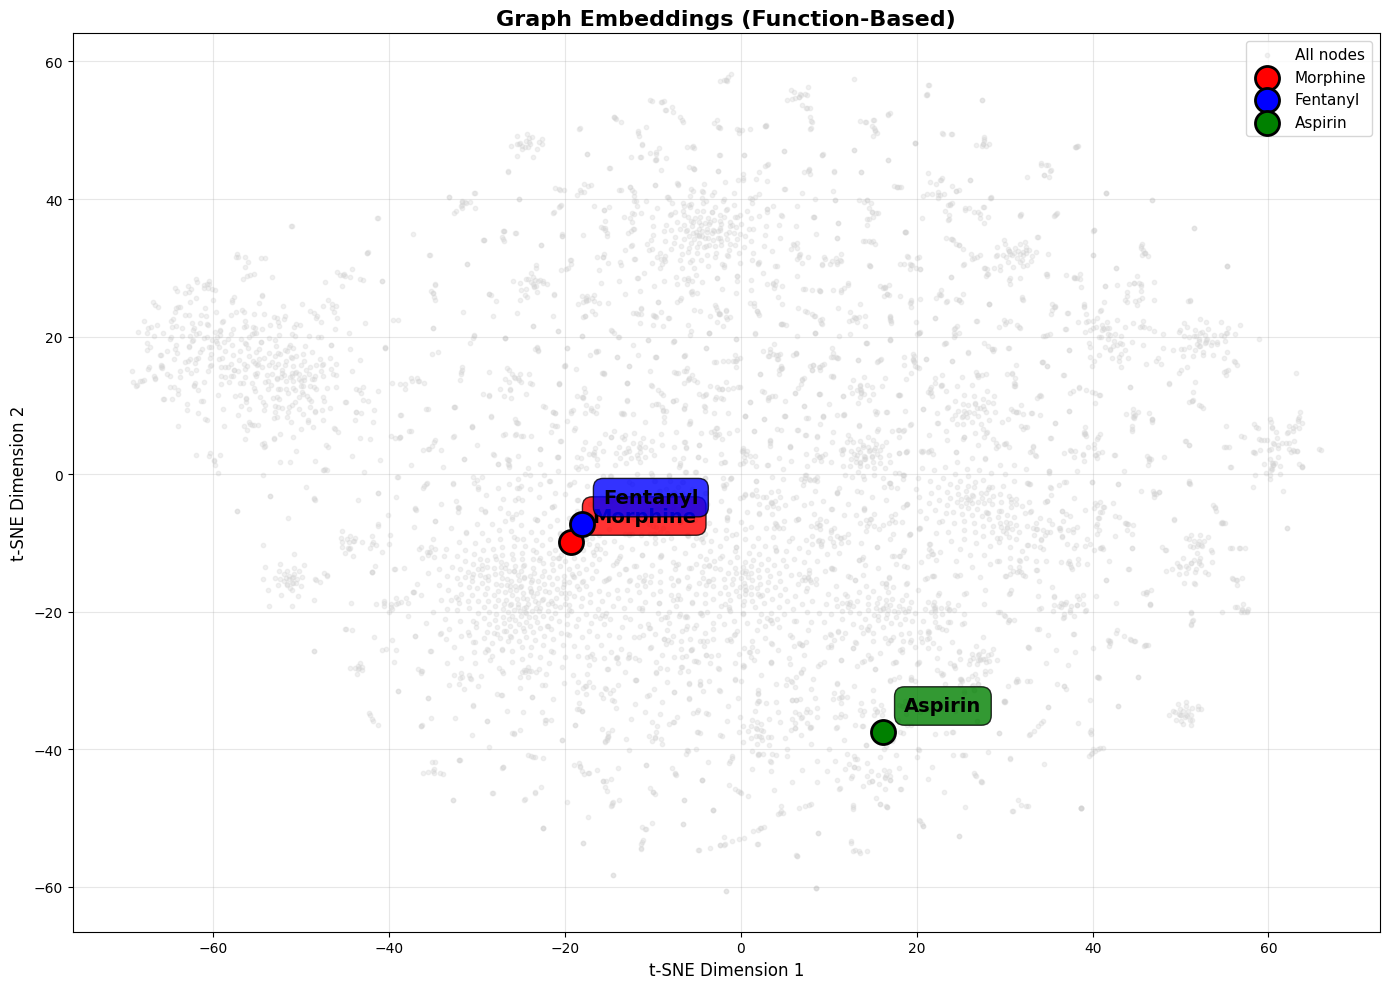


ANALYSIS

✅ Model learned that Morphine & Fentanyl are MORE similar than Aspirin
⚠️  BUT similarities are low (0.19 vs 0.16)

Why low similarities?
  - TransE uses L2 distance, not cosine similarity
  - Only 100 epochs of training
  - Could improve with more training or better model


In [127]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("="*80)
print("VISUALIZING EMBEDDINGS")
print("="*80)

# Compute t-SNE
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)
print("✓ Done")

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all nodes
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
          c='lightgray', s=10, alpha=0.3, label='All nodes')

# Highlight gold drugs
colors = {'Morphine': 'red', 'Fentanyl': 'blue', 'Aspirin': 'green'}
for drug_name, idx in gold_indices.items():
    x, y = embeddings_2d[idx]
    ax.scatter(x, y, c=colors[drug_name], s=300, 
              edgecolors='black', linewidths=2, label=drug_name, zorder=5)
    ax.annotate(drug_name, (x, y), 
               xytext=(15, 15), textcoords='offset points',
               fontsize=14, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', 
                        facecolor=colors[drug_name], alpha=0.8))

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('Graph Embeddings (Function-Based)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graph_visualization.png', dpi=300)
print("✓ Saved graph_visualization.png")
plt.show()

print("\n" + "="*80)
print("ANALYSIS")
print("="*80)
print("\n✅ Model learned that Morphine & Fentanyl are MORE similar than Aspirin")
print("⚠️  BUT similarities are low (0.19 vs 0.16)")
print("\nWhy low similarities?")
print("  - TransE uses L2 distance, not cosine similarity")
print("  - Only 100 epochs of training")
print("  - Could improve with more training or better model")

In [129]:
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("RANDOM DRUG NEAREST NEIGHBORS")
print("="*80)

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
print(f"Total drug nodes in graph: {len(drug_nodes)}")

# Randomly pick 5 drugs
random.seed(42)
random_drugs = random.sample(drug_nodes, 5)

# Create reverse mapping: internal_id -> drug info
# Use approved_drugs instead of drugs_df
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

print("\nFinding nearest neighbors for 5 random drugs...\n")

for i, drug_internal_id in enumerate(random_drugs, 1):
    # Get drug info
    if drug_internal_id not in internal_to_info:
        continue
    
    chembl_id, drug_name = internal_to_info[drug_internal_id]
    
    # Get embedding index
    drug_idx = node_to_idx[drug_internal_id]
    drug_emb = embeddings[drug_idx].reshape(1, -1)
    
    print(f"{i}. {drug_name} ({chembl_id})")
    print("   " + "-"*60)
    
    # Compute similarities to all other drugs
    similarities = []
    for other_internal_id in drug_nodes:
        if other_internal_id == drug_internal_id:
            continue
        if other_internal_id not in node_to_idx:
            continue
        
        other_idx = node_to_idx[other_internal_id]
        other_emb = embeddings[other_idx].reshape(1, -1)
        sim = cosine_similarity(drug_emb, other_emb)[0][0]
        
        if other_internal_id in internal_to_info:
            other_chembl, other_name = internal_to_info[other_internal_id]
            similarities.append((sim, other_name, other_chembl))
    
    # Get top 3
    similarities.sort(reverse=True)
    top_3 = similarities[:3]
    
    print("   Top 3 most similar drugs:")
    for rank, (sim, name, chembl) in enumerate(top_3, 1):
        print(f"      {rank}. {name} ({chembl}): similarity = {sim:.4f}")
    
    print()

print("="*80)

RANDOM DRUG NEAREST NEIGHBORS
Total drug nodes in graph: 2483

Finding nearest neighbors for 5 random drugs...

1. GLYCOPYRRONIUM BROMIDE (CHEMBL1201027)
   ------------------------------------------------------------
   Top 3 most similar drugs:
      1. TIOTROPIUM BROMIDE (CHEMBL3545181): similarity = 0.4911
      2. TROPICAMIDE (CHEMBL1200604): similarity = 0.4624
      3. DIPHEMANIL (CHEMBL1201340): similarity = 0.4438

2. RIMONABANT (CHEMBL111)
   ------------------------------------------------------------
   Top 3 most similar drugs:
      1. ORLISTAT (CHEMBL175247): similarity = 0.4496
      2. GLIPIZIDE (CHEMBL1073): similarity = 0.4351
      3. DIETHYLPROPION (CHEMBL1194666): similarity = 0.4193

3. ACYCLOVIR (CHEMBL184)
   ------------------------------------------------------------
   Top 3 most similar drugs:
      1. FAMCICLOVIR (CHEMBL880): similarity = 0.4540
      2. TRIFLURIDINE (CHEMBL1129): similarity = 0.4124
      3. VALACYCLOVIR (CHEMBL1349): similarity = 0.3638


ENHANCED DRUG VISUALIZATION
Computing t-SNE...
✓ Done

Node counts:
  Drugs: 2483
  Proteins: 1145
  Effects: 983

✓ Saved graph_embeddings_visualization.png


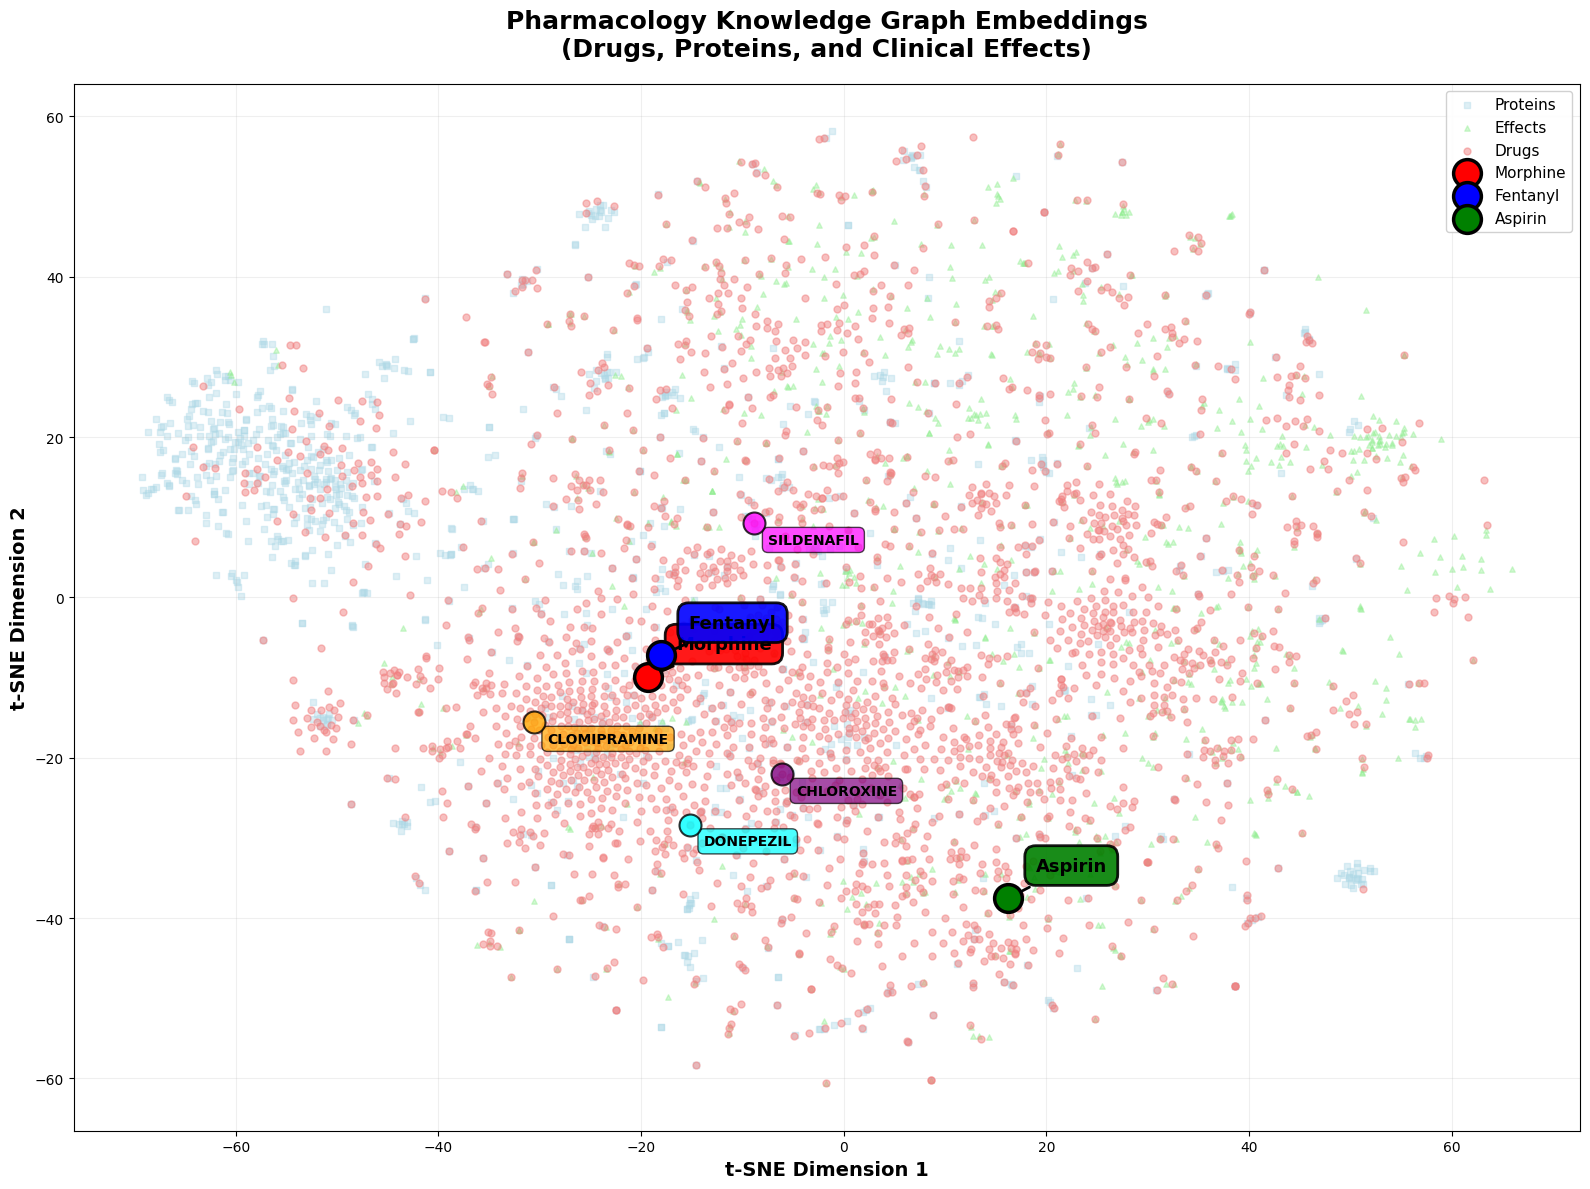


VISUALIZATION COMPLETE


In [130]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

print("="*80)
print("ENHANCED DRUG VISUALIZATION")
print("="*80)

# Compute t-SNE
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)
print("✓ Done")

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
protein_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'protein']
effect_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'effect']

print(f"\nNode counts:")
print(f"  Drugs: {len(drug_nodes)}")
print(f"  Proteins: {len(protein_nodes_list)}")
print(f"  Effects: {len(effect_nodes)}")

# Create reverse mapping: internal_id -> drug info
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

# Create visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Separate coordinates by node type
drug_coords = []
protein_coords = []
effect_coords = []

for node in G_main.nodes():
    idx = node_to_idx[node]
    node_type = G_main.nodes[node].get('node_type')
    
    if node_type == 'drug':
        drug_coords.append(embeddings_2d[idx])
    elif node_type == 'protein':
        protein_coords.append(embeddings_2d[idx])
    elif node_type == 'effect':
        effect_coords.append(embeddings_2d[idx])

# Convert to arrays
drug_coords = np.array(drug_coords)
protein_coords = np.array(protein_coords)
effect_coords = np.array(effect_coords)

# Plot by node type
ax.scatter(protein_coords[:, 0], protein_coords[:, 1], 
          c='lightblue', s=15, alpha=0.4, label='Proteins', marker='s')
ax.scatter(effect_coords[:, 0], effect_coords[:, 1], 
          c='lightgreen', s=15, alpha=0.4, label='Effects', marker='^')
ax.scatter(drug_coords[:, 0], drug_coords[:, 1], 
          c='lightcoral', s=25, alpha=0.5, label='Drugs', marker='o')

# Highlight gold standard drugs
gold_drugs = {
    'CHEMBL70': 'Morphine',
    'CHEMBL596': 'Fentanyl', 
    'CHEMBL25': 'Aspirin'
}

colors = {'Morphine': 'red', 'Fentanyl': 'blue', 'Aspirin': 'green'}
gold_indices = {}

for chembl_id, drug_name in gold_drugs.items():
    chembl_to_internal = dict(zip(approved_drugs['drug_id'], approved_drugs['drug_internal_id']))
    if chembl_id in chembl_to_internal:
        internal_id = chembl_to_internal[chembl_id]
        if internal_id in node_to_idx:
            idx = node_to_idx[internal_id]
            gold_indices[drug_name] = idx
            x, y = embeddings_2d[idx]
            ax.scatter(x, y, c=colors[drug_name], s=400, 
                      edgecolors='black', linewidths=2.5, label=drug_name, zorder=10)
            ax.annotate(drug_name, (x, y), 
                       xytext=(20, 20), textcoords='offset points',
                       fontsize=13, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.6', 
                                facecolor=colors[drug_name], alpha=0.9, edgecolor='black', linewidth=2),
                       arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# Pick some interesting drugs to highlight
interesting_drugs = [
    'CHEMBL415', # Ibuprofen
    'CHEMBL1200596', # Paracetamol/Acetaminophen
    'CHEMBL1201055', # Penicillin V
    'CHEMBL192', # Metformin
    'CHEMBL502', # Warfarin
]

highlight_colors = ['orange', 'purple', 'brown', 'magenta', 'cyan']

for chembl_id, color in zip(interesting_drugs, highlight_colors):
    chembl_to_internal = dict(zip(approved_drugs['drug_id'], approved_drugs['drug_internal_id']))
    if chembl_id in chembl_to_internal:
        internal_id = chembl_to_internal[chembl_id]
        if internal_id in node_to_idx:
            idx = node_to_idx[internal_id]
            x, y = embeddings_2d[idx]
            chembl_id_val, drug_name = internal_to_info.get(internal_id, (chembl_id, 'Unknown'))
            ax.scatter(x, y, c=color, s=250, 
                      edgecolors='black', linewidths=1.5, alpha=0.8, zorder=9)
            ax.annotate(drug_name, (x, y), 
                       xytext=(10, -15), textcoords='offset points',
                       fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.4', 
                                facecolor=color, alpha=0.7, edgecolor='black', linewidth=1))

ax.set_xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('Pharmacology Knowledge Graph Embeddings\n(Drugs, Proteins, and Clinical Effects)', 
            fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('graph_embeddings_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved graph_embeddings_visualization.png")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

In [131]:
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("RANDOM DRUG NEAREST NEIGHBORS - TOP 5")
print("="*80)

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
print(f"Total drug nodes in graph: {len(drug_nodes)}")

# Randomly pick 5 drugs
random.seed(42)
random_drugs = random.sample(drug_nodes, 5)

# Create reverse mapping: internal_id -> drug info
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

print("\nFinding top 5 nearest neighbors for 5 random drugs...\n")

for i, drug_internal_id in enumerate(random_drugs, 1):
    # Get drug info
    if drug_internal_id not in internal_to_info:
        continue
    
    chembl_id, drug_name = internal_to_info[drug_internal_id]
    
    # Get embedding index
    drug_idx = node_to_idx[drug_internal_id]
    drug_emb = embeddings[drug_idx].reshape(1, -1)
    
    print(f"{i}. {drug_name} ({chembl_id})")
    print("   " + "-"*70)
    
    # Compute similarities to all other drugs
    similarities = []
    for other_internal_id in drug_nodes:
        if other_internal_id == drug_internal_id:
            continue
        if other_internal_id not in node_to_idx:
            continue
        
        other_idx = node_to_idx[other_internal_id]
        other_emb = embeddings[other_idx].reshape(1, -1)
        sim = cosine_similarity(drug_emb, other_emb)[0][0]
        
        if other_internal_id in internal_to_info:
            other_chembl, other_name = internal_to_info[other_internal_id]
            similarities.append((sim, other_name, other_chembl))
    
    # Get top 5
    similarities.sort(reverse=True)
    top_5 = similarities[:5]
    
    print("   Top 5 most similar drugs:")
    for rank, (sim, name, chembl) in enumerate(top_5, 1):
        print(f"      {rank}. {name:40s} ({chembl:15s}) similarity = {sim:.4f}")
    
    print()

print("="*80)

RANDOM DRUG NEAREST NEIGHBORS - TOP 5
Total drug nodes in graph: 2483

Finding top 5 nearest neighbors for 5 random drugs...

1. GLYCOPYRRONIUM BROMIDE (CHEMBL1201027)
   ----------------------------------------------------------------------
   Top 5 most similar drugs:
      1. TIOTROPIUM BROMIDE                       (CHEMBL3545181  ) similarity = 0.4911
      2. TROPICAMIDE                              (CHEMBL1200604  ) similarity = 0.4624
      3. DIPHEMANIL                               (CHEMBL1201340  ) similarity = 0.4438
      4. UMECLIDINIUM BROMIDE                     (CHEMBL523299   ) similarity = 0.4434
      5. ACLIDINIUM BROMIDE                       (CHEMBL551466   ) similarity = 0.4383

2. RIMONABANT (CHEMBL111)
   ----------------------------------------------------------------------
   Top 5 most similar drugs:
      1. ORLISTAT                                 (CHEMBL175247   ) similarity = 0.4496
      2. GLIPIZIDE                                (CHEMBL1073     ) sim

ENHANCED DRUG VISUALIZATION WITH NEAREST NEIGHBORS
Computing t-SNE...
✓ Done

Node counts:
  Drugs: 2483
  Proteins: 1145
  Effects: 983

Finding random drugs and their neighbors...

✓ Saved drug_neighbors_visualization.png


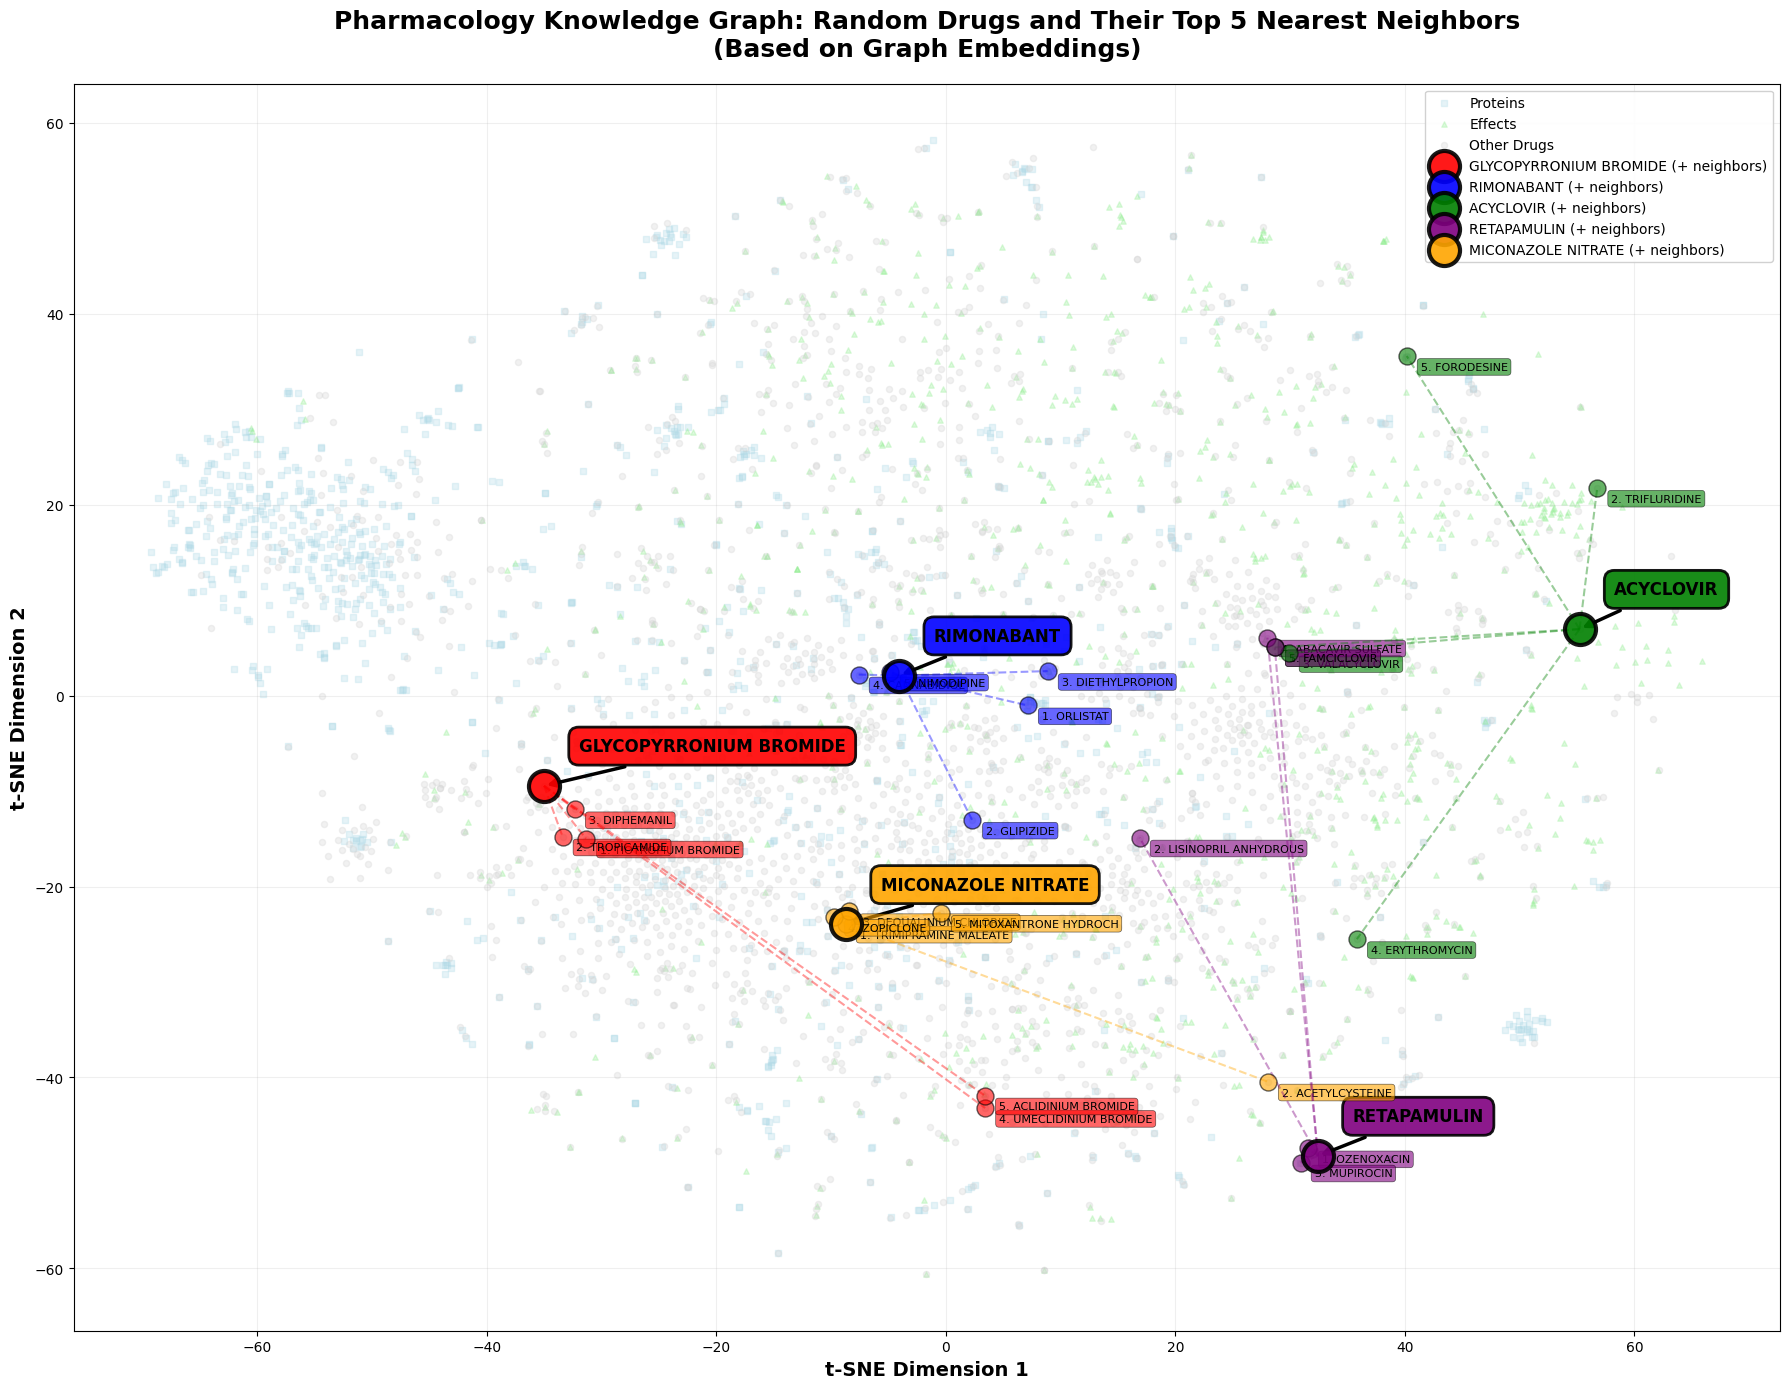


VISUALIZATION COMPLETE

Summary of visualized drug clusters:

1. GLYCOPYRRONIUM BROMIDE (CHEMBL1201027):
   1. TIOTROPIUM BROMIDE                       (similarity: 0.4911)
   2. TROPICAMIDE                              (similarity: 0.4624)
   3. DIPHEMANIL                               (similarity: 0.4438)
   4. UMECLIDINIUM BROMIDE                     (similarity: 0.4434)
   5. ACLIDINIUM BROMIDE                       (similarity: 0.4383)

2. RIMONABANT (CHEMBL111):
   1. ORLISTAT                                 (similarity: 0.4496)
   2. GLIPIZIDE                                (similarity: 0.4351)
   3. DIETHYLPROPION                           (similarity: 0.4193)
   4. CANNABIDIOL                              (similarity: 0.3997)
   5. NIMODIPINE                               (similarity: 0.3668)

3. ACYCLOVIR (CHEMBL184):
   1. FAMCICLOVIR                              (similarity: 0.4540)
   2. TRIFLURIDINE                             (similarity: 0.4124)
   3. VALACYCLOVIR     

In [132]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("ENHANCED DRUG VISUALIZATION WITH NEAREST NEIGHBORS")
print("="*80)

# Compute t-SNE
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)
print("✓ Done")

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
protein_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'protein']
effect_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'effect']

print(f"\nNode counts:")
print(f"  Drugs: {len(drug_nodes)}")
print(f"  Proteins: {len(protein_nodes_list)}")
print(f"  Effects: {len(effect_nodes)}")

# Create reverse mapping: internal_id -> drug info
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

# Randomly pick 5 drugs and find their top 5 neighbors
print("\nFinding random drugs and their neighbors...")
random.seed(42)
random_drugs = random.sample(drug_nodes, 5)

random_drug_data = []
for drug_internal_id in random_drugs:
    if drug_internal_id not in internal_to_info:
        continue
    
    chembl_id, drug_name = internal_to_info[drug_internal_id]
    drug_idx = node_to_idx[drug_internal_id]
    drug_emb = embeddings[drug_idx].reshape(1, -1)
    
    # Find top 5 neighbors
    similarities = []
    for other_internal_id in drug_nodes:
        if other_internal_id == drug_internal_id:
            continue
        if other_internal_id not in node_to_idx:
            continue
        
        other_idx = node_to_idx[other_internal_id]
        other_emb = embeddings[other_idx].reshape(1, -1)
        sim = cosine_similarity(drug_emb, other_emb)[0][0]
        
        if other_internal_id in internal_to_info:
            other_chembl, other_name = internal_to_info[other_internal_id]
            similarities.append((sim, other_name, other_chembl, other_internal_id, other_idx))
    
    similarities.sort(reverse=True)
    top_5 = similarities[:5]
    
    random_drug_data.append({
        'name': drug_name,
        'chembl': chembl_id,
        'internal_id': drug_internal_id,
        'idx': drug_idx,
        'neighbors': top_5
    })

# Create visualization
fig, ax = plt.subplots(figsize=(18, 14))

# Separate coordinates by node type
drug_coords = []
protein_coords = []
effect_coords = []

for node in G_main.nodes():
    idx = node_to_idx[node]
    node_type = G_main.nodes[node].get('node_type')
    
    if node_type == 'drug':
        drug_coords.append(embeddings_2d[idx])
    elif node_type == 'protein':
        protein_coords.append(embeddings_2d[idx])
    elif node_type == 'effect':
        effect_coords.append(embeddings_2d[idx])

# Convert to arrays
drug_coords = np.array(drug_coords)
protein_coords = np.array(protein_coords)
effect_coords = np.array(effect_coords)

# Plot by node type (background)
ax.scatter(protein_coords[:, 0], protein_coords[:, 1], 
          c='lightblue', s=15, alpha=0.3, label='Proteins', marker='s')
ax.scatter(effect_coords[:, 0], effect_coords[:, 1], 
          c='lightgreen', s=15, alpha=0.3, label='Effects', marker='^')
ax.scatter(drug_coords[:, 0], drug_coords[:, 1], 
          c='lightgray', s=20, alpha=0.3, label='Other Drugs', marker='o')

# Define colors for random drugs
main_colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot random drugs and their neighbors
for i, drug_data in enumerate(random_drug_data):
    main_color = main_colors[i]
    
    # Plot main drug (larger)
    x_main, y_main = embeddings_2d[drug_data['idx']]
    ax.scatter(x_main, y_main, c=main_color, s=500, 
              edgecolors='black', linewidths=3, alpha=0.9, zorder=10,
              label=f"{drug_data['name']} (+ neighbors)")
    
    # Annotate main drug
    ax.annotate(drug_data['name'], (x_main, y_main), 
               xytext=(25, 25), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.6', 
                        facecolor=main_color, alpha=0.9, 
                        edgecolor='black', linewidth=2),
               arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))
    
    # Plot top 5 neighbors (smaller, same color family)
    for rank, (sim, neighbor_name, neighbor_chembl, neighbor_internal_id, neighbor_idx) in enumerate(drug_data['neighbors'], 1):
        x_neighbor, y_neighbor = embeddings_2d[neighbor_idx]
        
        # Draw connecting line
        ax.plot([x_main, x_neighbor], [y_main, y_neighbor], 
               color=main_color, alpha=0.4, linewidth=1.5, linestyle='--', zorder=5)
        
        # Plot neighbor
        ax.scatter(x_neighbor, y_neighbor, c=main_color, s=150, 
                  edgecolors='black', linewidths=1, alpha=0.6, zorder=8)
        
        # Annotate neighbor with rank
        ax.annotate(f"{rank}. {neighbor_name[:20]}", (x_neighbor, y_neighbor), 
                   xytext=(10, -10), textcoords='offset points',
                   fontsize=8, 
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor=main_color, alpha=0.6, 
                            edgecolor='black', linewidth=0.5))

ax.set_xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('Pharmacology Knowledge Graph: Random Drugs and Their Top 5 Nearest Neighbors\n(Based on Graph Embeddings)', 
            fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('drug_neighbors_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved drug_neighbors_visualization.png")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

# Print summary
print("\nSummary of visualized drug clusters:")
for i, drug_data in enumerate(random_drug_data, 1):
    print(f"\n{i}. {drug_data['name']} ({drug_data['chembl']}):")
    for rank, (sim, name, chembl, _, _) in enumerate(drug_data['neighbors'], 1):
        print(f"   {rank}. {name:40s} (similarity: {sim:.4f})")

DRUG-ONLY VISUALIZATION WITH NEAREST NEIGHBORS

Total drug nodes: 2483
Drug embeddings shape: (2483, 128)

Computing t-SNE for drugs only...
✓ Done

Finding random drugs and their neighbors...

✓ Saved drug_neighbors_visualization.png


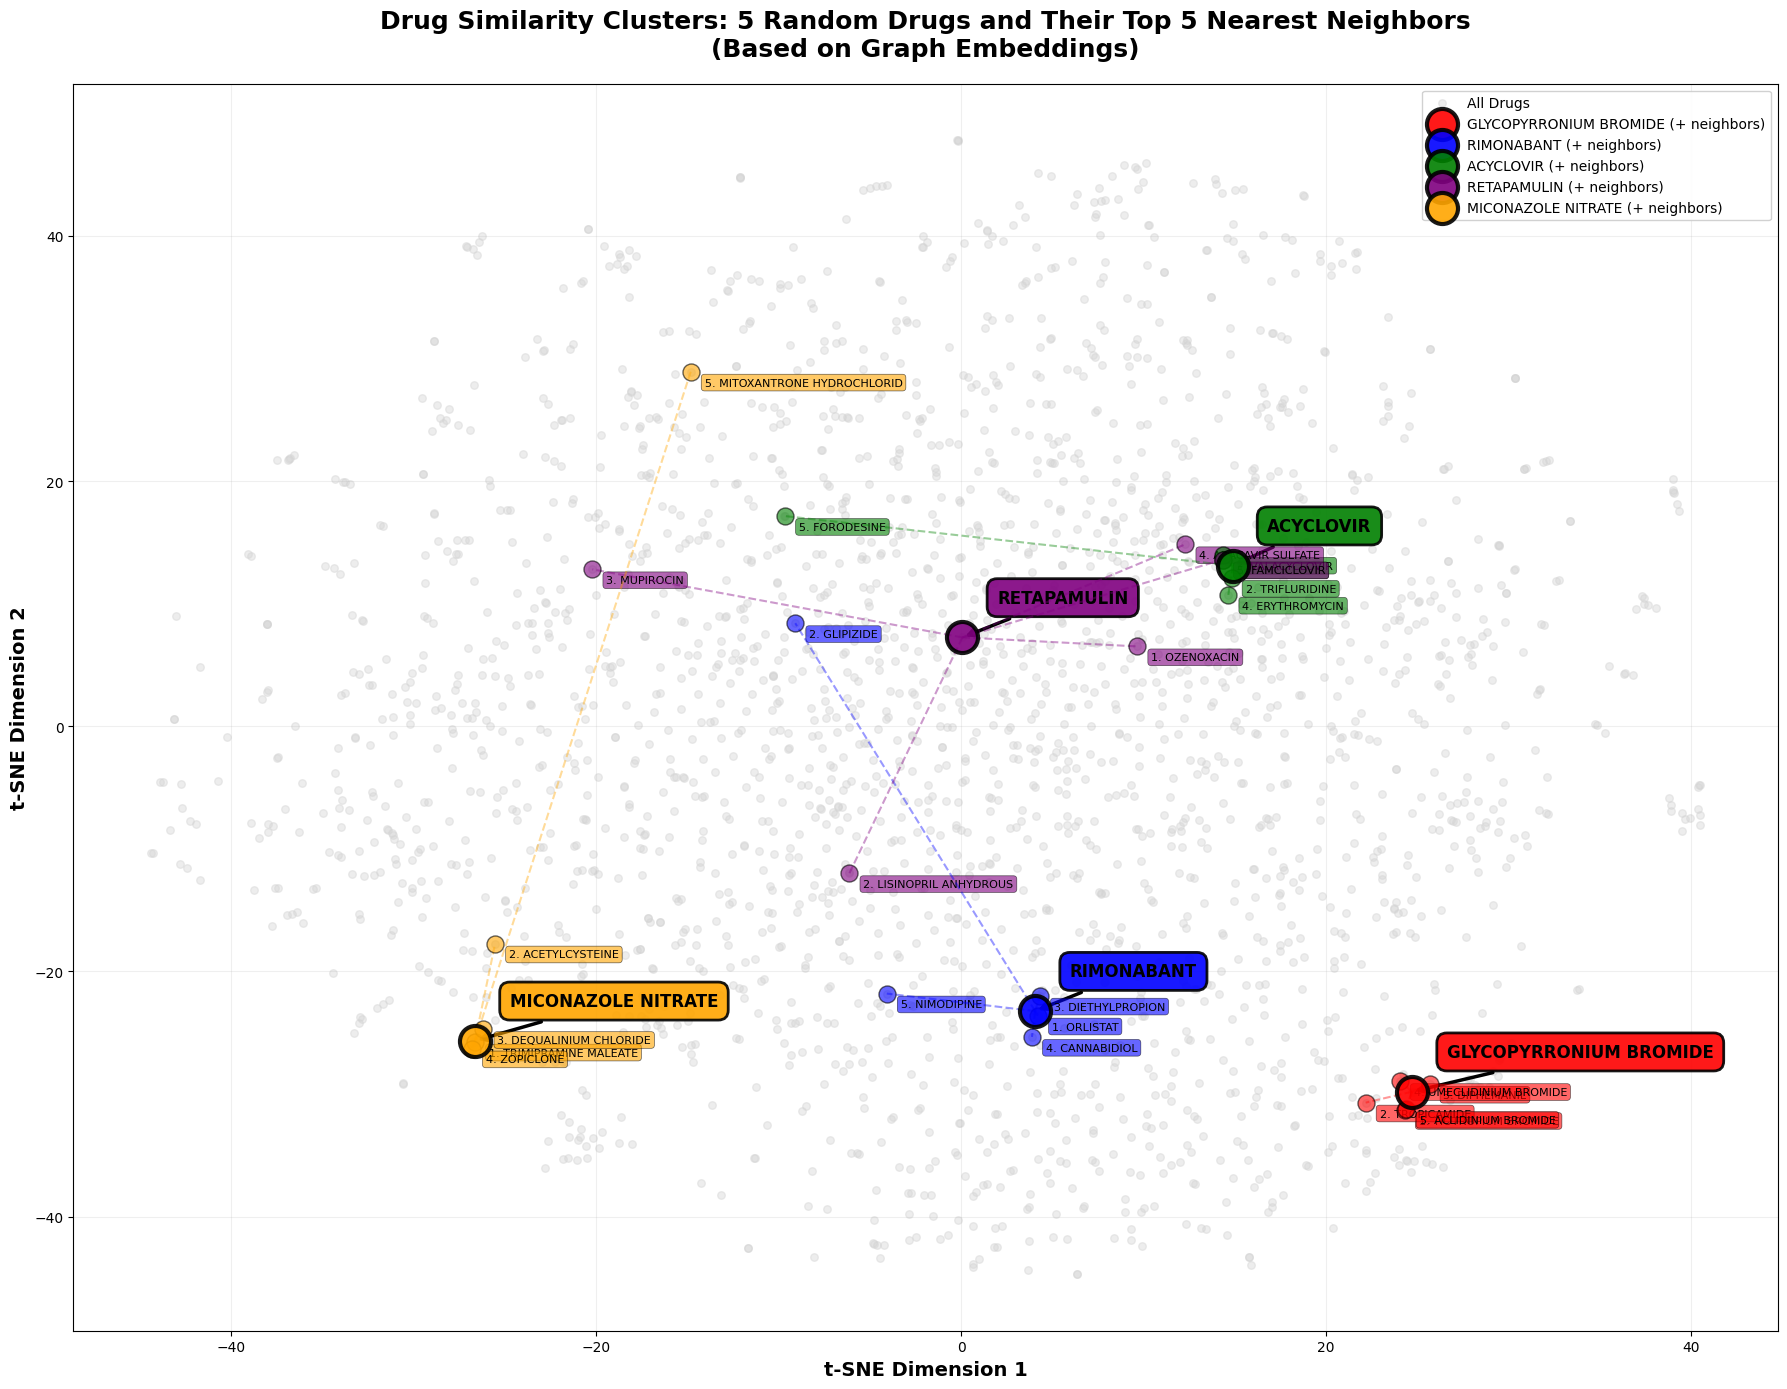


VISUALIZATION COMPLETE

Summary of visualized drug clusters:

1. GLYCOPYRRONIUM BROMIDE (CHEMBL1201027):
   1. TIOTROPIUM BROMIDE                       (similarity: 0.4911)
   2. TROPICAMIDE                              (similarity: 0.4624)
   3. DIPHEMANIL                               (similarity: 0.4438)
   4. UMECLIDINIUM BROMIDE                     (similarity: 0.4434)
   5. ACLIDINIUM BROMIDE                       (similarity: 0.4383)

2. RIMONABANT (CHEMBL111):
   1. ORLISTAT                                 (similarity: 0.4496)
   2. GLIPIZIDE                                (similarity: 0.4351)
   3. DIETHYLPROPION                           (similarity: 0.4193)
   4. CANNABIDIOL                              (similarity: 0.3997)
   5. NIMODIPINE                               (similarity: 0.3668)

3. ACYCLOVIR (CHEMBL184):
   1. FAMCICLOVIR                              (similarity: 0.4540)
   2. TRIFLURIDINE                             (similarity: 0.4124)
   3. VALACYCLOVIR     

In [133]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("DRUG-ONLY VISUALIZATION WITH NEAREST NEIGHBORS")
print("="*80)

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
print(f"\nTotal drug nodes: {len(drug_nodes)}")

# Extract only drug embeddings
drug_indices = []
drug_internal_ids = []

for node in drug_nodes:
    idx = node_to_idx[node]
    drug_indices.append(idx)
    drug_internal_ids.append(node)

drug_embeddings = embeddings[drug_indices]
print(f"Drug embeddings shape: {drug_embeddings.shape}")

# Compute t-SNE only on drug embeddings
print("\nComputing t-SNE for drugs only...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(drug_nodes)-1))
drug_embeddings_2d = tsne.fit_transform(drug_embeddings)
print("✓ Done")

# Create reverse mapping: internal_id -> drug info
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

# Randomly pick 5 drugs and find their top 5 neighbors
print("\nFinding random drugs and their neighbors...")
random.seed(42)
random_drugs = random.sample(drug_nodes, 5)

random_drug_data = []
for drug_internal_id in random_drugs:
    if drug_internal_id not in internal_to_info:
        continue
    
    chembl_id, drug_name = internal_to_info[drug_internal_id]
    
    # Find the index in drug_nodes list
    drug_list_idx = drug_internal_ids.index(drug_internal_id)
    drug_emb = drug_embeddings[drug_list_idx].reshape(1, -1)
    
    # Find top 5 neighbors among all drugs
    similarities = []
    for other_list_idx, other_internal_id in enumerate(drug_internal_ids):
        if other_internal_id == drug_internal_id:
            continue
        
        other_emb = drug_embeddings[other_list_idx].reshape(1, -1)
        sim = cosine_similarity(drug_emb, other_emb)[0][0]
        
        if other_internal_id in internal_to_info:
            other_chembl, other_name = internal_to_info[other_internal_id]
            similarities.append((sim, other_name, other_chembl, other_internal_id, other_list_idx))
    
    similarities.sort(reverse=True)
    top_5 = similarities[:5]
    
    random_drug_data.append({
        'name': drug_name,
        'chembl': chembl_id,
        'internal_id': drug_internal_id,
        'idx': drug_list_idx,
        'neighbors': top_5
    })

# Create visualization
fig, ax = plt.subplots(figsize=(18, 14))

# Plot all drugs as background
ax.scatter(drug_embeddings_2d[:, 0], drug_embeddings_2d[:, 1], 
          c='lightgray', s=30, alpha=0.4, label='All Drugs', marker='o')

# Define colors for random drugs
main_colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot random drugs and their neighbors
for i, drug_data in enumerate(random_drug_data):
    main_color = main_colors[i]
    
    # Plot main drug (larger)
    x_main, y_main = drug_embeddings_2d[drug_data['idx']]
    ax.scatter(x_main, y_main, c=main_color, s=500, 
              edgecolors='black', linewidths=3, alpha=0.9, zorder=10,
              label=f"{drug_data['name']} (+ neighbors)")
    
    # Annotate main drug
    ax.annotate(drug_data['name'], (x_main, y_main), 
               xytext=(25, 25), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.6', 
                        facecolor=main_color, alpha=0.9, 
                        edgecolor='black', linewidth=2),
               arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))
    
    # Plot top 5 neighbors (smaller, same color family)
    for rank, (sim, neighbor_name, neighbor_chembl, neighbor_internal_id, neighbor_list_idx) in enumerate(drug_data['neighbors'], 1):
        x_neighbor, y_neighbor = drug_embeddings_2d[neighbor_list_idx]
        
        # Draw connecting line
        ax.plot([x_main, x_neighbor], [y_main, y_neighbor], 
               color=main_color, alpha=0.4, linewidth=1.5, linestyle='--', zorder=5)
        
        # Plot neighbor
        ax.scatter(x_neighbor, y_neighbor, c=main_color, s=150, 
                  edgecolors='black', linewidths=1, alpha=0.6, zorder=8)
        
        # Annotate neighbor with rank
        ax.annotate(f"{rank}. {neighbor_name[:25]}", (x_neighbor, y_neighbor), 
                   xytext=(10, -10), textcoords='offset points',
                   fontsize=8, 
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor=main_color, alpha=0.6, 
                            edgecolor='black', linewidth=0.5))

ax.set_xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('Drug Similarity Clusters: 5 Random Drugs and Their Top 5 Nearest Neighbors\n(Based on Graph Embeddings)', 
            fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('drug_neighbors_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved drug_neighbors_visualization.png")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

# Print summary
print("\nSummary of visualized drug clusters:")
for i, drug_data in enumerate(random_drug_data, 1):
    print(f"\n{i}. {drug_data['name']} ({drug_data['chembl']}):")
    for rank, (sim, name, chembl, _, _) in enumerate(drug_data['neighbors'], 1):
        print(f"   {rank}. {name:40s} (similarity: {sim:.4f})")

DRUG-ONLY VISUALIZATION WITH NEAREST NEIGHBORS

Total drug nodes: 2483
Drug embeddings shape: (2483, 128)

Computing t-SNE for drugs only...
✓ Done

Finding random drugs and their neighbors...

✓ Saved drug_neighbors_visualization.png


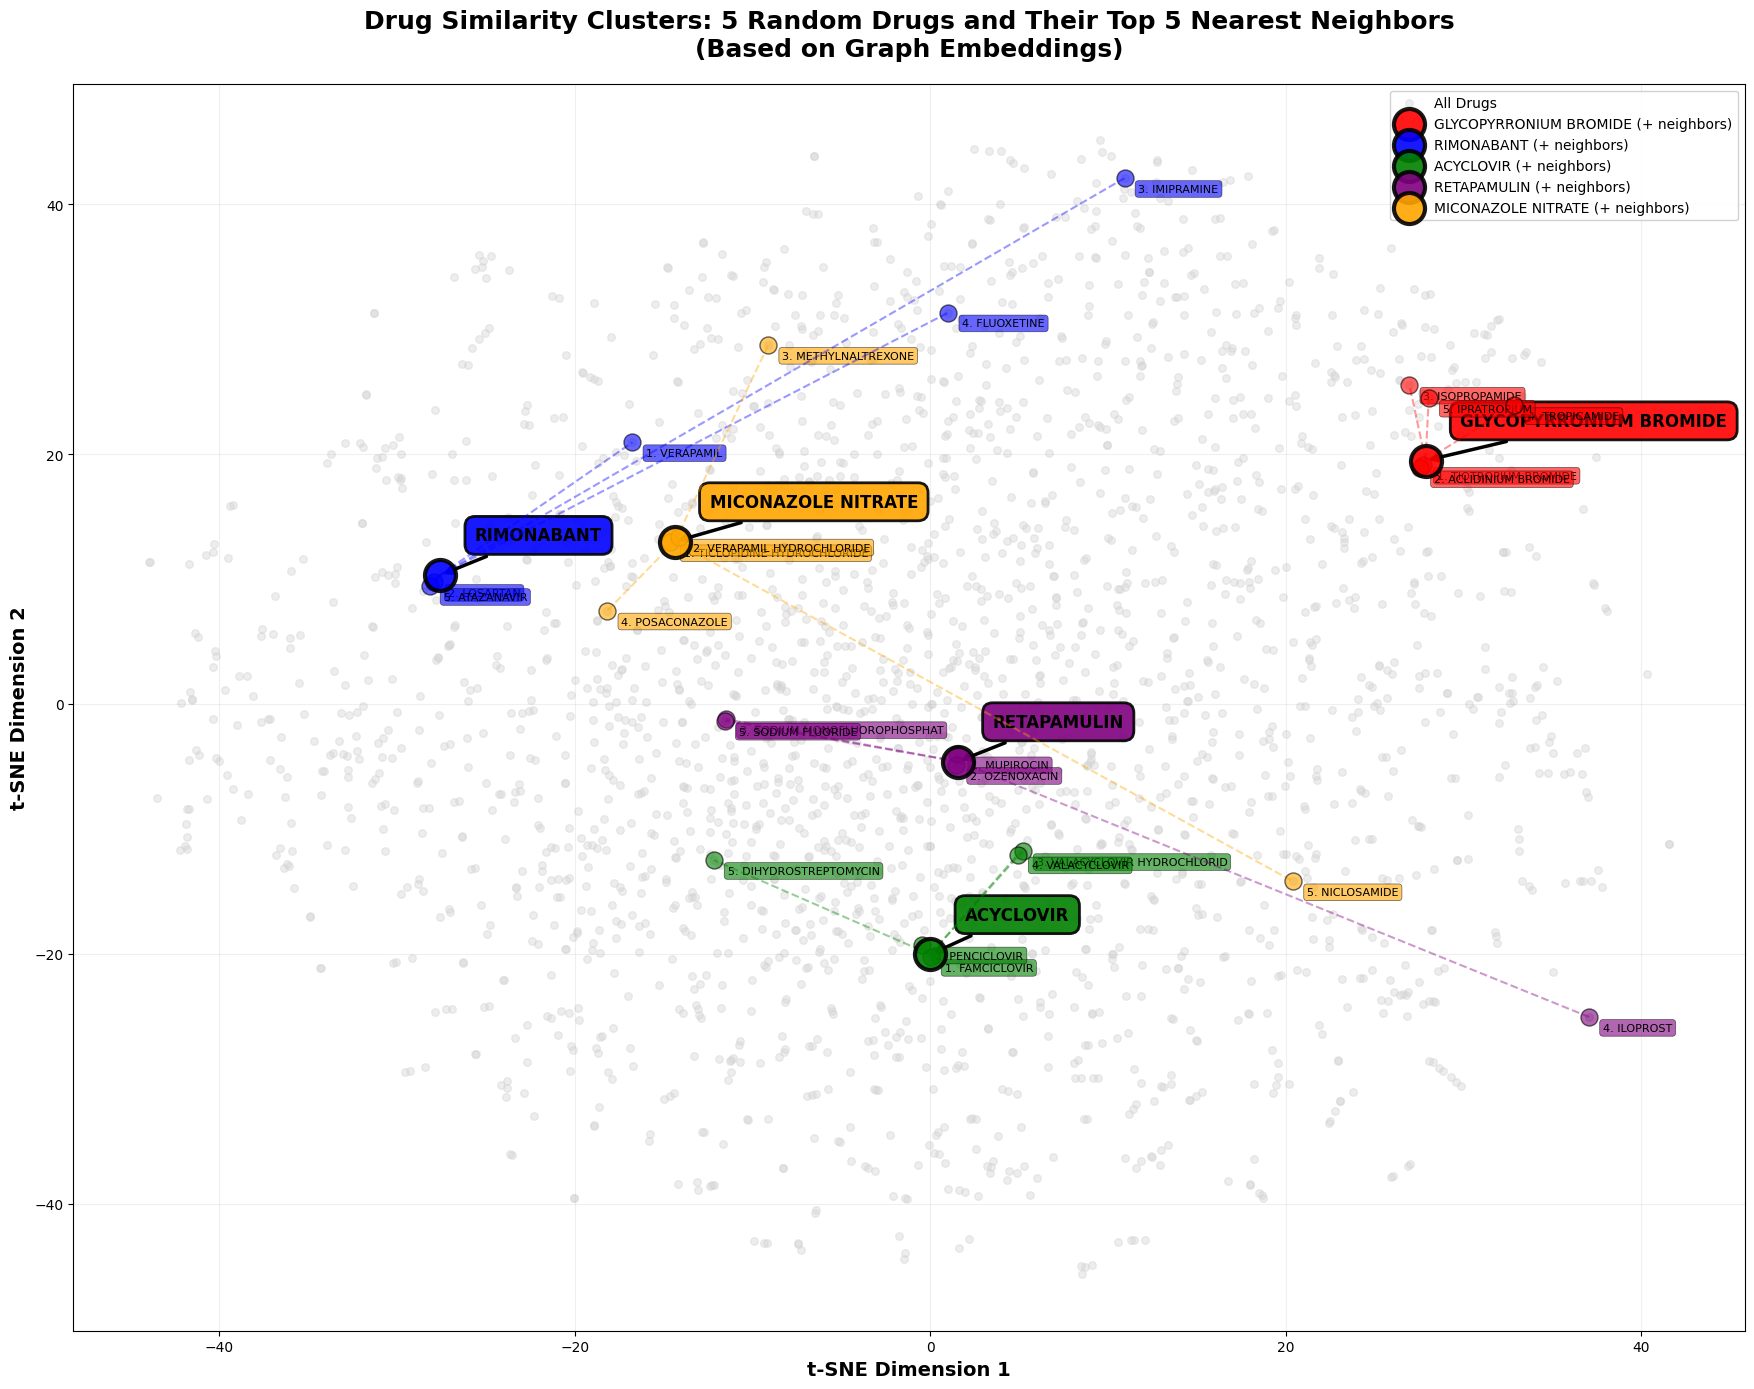


VISUALIZATION COMPLETE

Summary of visualized drug clusters:

1. GLYCOPYRRONIUM BROMIDE (CHEMBL1201027):
   1. TIOTROPIUM BROMIDE                       (similarity: 0.5107)
   2. ACLIDINIUM BROMIDE                       (similarity: 0.4198)
   3. ISOPROPAMIDE                             (similarity: 0.4124)
   4. TROPICAMIDE                              (similarity: 0.4067)
   5. IPRATROPIUM                              (similarity: 0.3930)

2. RIMONABANT (CHEMBL111):
   1. VERAPAMIL                                (similarity: 0.4125)
   2. LOSARTAN                                 (similarity: 0.3755)
   3. IMIPRAMINE                               (similarity: 0.3600)
   4. FLUOXETINE                               (similarity: 0.3320)
   5. ATAZANAVIR                               (similarity: 0.3258)

3. ACYCLOVIR (CHEMBL184):
   1. FAMCICLOVIR                              (similarity: 0.5186)
   2. PENCICLOVIR                              (similarity: 0.4172)
   3. VALACYCLOVIR HYDR

In [135]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("DRUG-ONLY VISUALIZATION WITH NEAREST NEIGHBORS")
print("="*80)

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
print(f"\nTotal drug nodes: {len(drug_nodes)}")

# Extract only drug embeddings
drug_indices = []
drug_internal_ids = []

for node in drug_nodes:
    idx = node_to_idx[node]
    drug_indices.append(idx)
    drug_internal_ids.append(node)

drug_embeddings = embeddings[drug_indices]
print(f"Drug embeddings shape: {drug_embeddings.shape}")

# Compute t-SNE only on drug embeddings
print("\nComputing t-SNE for drugs only...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(drug_nodes)-1))
drug_embeddings_2d = tsne.fit_transform(drug_embeddings)
print("✓ Done")

# Create reverse mapping: internal_id -> drug info
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

# Randomly pick 5 drugs and find their top 5 neighbors
print("\nFinding random drugs and their neighbors...")
random.seed(42)
random_drugs = random.sample(drug_nodes, 5)

random_drug_data = []
for drug_internal_id in random_drugs:
    if drug_internal_id not in internal_to_info:
        continue
    
    chembl_id, drug_name = internal_to_info[drug_internal_id]
    
    # Find the index in drug_nodes list
    drug_list_idx = drug_internal_ids.index(drug_internal_id)
    drug_emb = drug_embeddings[drug_list_idx].reshape(1, -1)
    
    # Find top 5 neighbors among all drugs
    similarities = []
    for other_list_idx, other_internal_id in enumerate(drug_internal_ids):
        if other_internal_id == drug_internal_id:
            continue
        
        other_emb = drug_embeddings[other_list_idx].reshape(1, -1)
        sim = cosine_similarity(drug_emb, other_emb)[0][0]
        
        if other_internal_id in internal_to_info:
            other_chembl, other_name = internal_to_info[other_internal_id]
            similarities.append((sim, other_name, other_chembl, other_internal_id, other_list_idx))
    
    similarities.sort(reverse=True)
    top_5 = similarities[:5]
    
    random_drug_data.append({
        'name': drug_name,
        'chembl': chembl_id,
        'internal_id': drug_internal_id,
        'idx': drug_list_idx,
        'neighbors': top_5
    })

# Create visualization
fig, ax = plt.subplots(figsize=(18, 14))

# Plot all drugs as background
ax.scatter(drug_embeddings_2d[:, 0], drug_embeddings_2d[:, 1], 
          c='lightgray', s=30, alpha=0.4, label='All Drugs', marker='o')

# Define colors for random drugs
main_colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot random drugs and their neighbors
for i, drug_data in enumerate(random_drug_data):
    main_color = main_colors[i]
    
    # Plot main drug (larger)
    x_main, y_main = drug_embeddings_2d[drug_data['idx']]
    ax.scatter(x_main, y_main, c=main_color, s=500, 
              edgecolors='black', linewidths=3, alpha=0.9, zorder=10,
              label=f"{drug_data['name']} (+ neighbors)")
    
    # Annotate main drug
    ax.annotate(drug_data['name'], (x_main, y_main), 
               xytext=(25, 25), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.6', 
                        facecolor=main_color, alpha=0.9, 
                        edgecolor='black', linewidth=2),
               arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))
    
    # Plot top 5 neighbors (smaller, same color family)
    for rank, (sim, neighbor_name, neighbor_chembl, neighbor_internal_id, neighbor_list_idx) in enumerate(drug_data['neighbors'], 1):
        x_neighbor, y_neighbor = drug_embeddings_2d[neighbor_list_idx]
        
        # Draw connecting line
        ax.plot([x_main, x_neighbor], [y_main, y_neighbor], 
               color=main_color, alpha=0.4, linewidth=1.5, linestyle='--', zorder=5)
        
        # Plot neighbor
        ax.scatter(x_neighbor, y_neighbor, c=main_color, s=150, 
                  edgecolors='black', linewidths=1, alpha=0.6, zorder=8)
        
        # Annotate neighbor with rank
        ax.annotate(f"{rank}. {neighbor_name[:25]}", (x_neighbor, y_neighbor), 
                   xytext=(10, -10), textcoords='offset points',
                   fontsize=8, 
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor=main_color, alpha=0.6, 
                            edgecolor='black', linewidth=0.5))

ax.set_xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('Drug Similarity Clusters: 5 Random Drugs and Their Top 5 Nearest Neighbors\n(Based on Graph Embeddings)', 
            fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('drug_neighbors_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved drug_neighbors_visualization.png")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

# Print summary
print("\nSummary of visualized drug clusters:")
for i, drug_data in enumerate(random_drug_data, 1):
    print(f"\n{i}. {drug_data['name']} ({drug_data['chembl']}):")
    for rank, (sim, name, chembl, _, _) in enumerate(drug_data['neighbors'], 1):
        print(f"   {rank}. {name:40s} (similarity: {sim:.4f})")

In [137]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("LINK PREDICTION: Predict Unknown Drug-Protein Edges")
print("="*80)

def predict_protein_targets(drug_chembl_id, top_k=10):
    """
    Given a drug, predict which proteins it might bind to
    based on embedding similarity.
    
    Args:
        drug_chembl_id: ChEMBL ID (e.g., 'CHEMBL70' for Morphine)
        top_k: Number of top predictions to return
    
    Returns:
        predictions: List of (protein_id, protein_name, similarity_score)
    """
    
    # Get drug's internal ID and embedding
    drug_row = approved_drugs[approved_drugs['drug_id'] == drug_chembl_id]
    if len(drug_row) == 0:
        print(f"❌ Drug {drug_chembl_id} not found")
        return None
    
    drug_internal_id = drug_row.iloc[0]['drug_internal_id']
    drug_name = drug_row.iloc[0]['drug_name']
    
    if drug_internal_id not in node_to_idx:
        print(f"❌ Drug not in graph")
        return None
    
    drug_idx = node_to_idx[drug_internal_id]
    drug_emb = embeddings[drug_idx].reshape(1, -1)
    
    print(f"\nPredicting targets for: {drug_name} ({drug_chembl_id})")
    
    # Get all KNOWN targets from the graph
    known_targets = set()
    drug_edges = drugs_interactions[drugs_interactions['drug_id'] == drug_chembl_id]
    known_targets = set(drug_edges['protein_id'].values)
    
    print(f"  Known targets: {len(known_targets)}")
    
    # Compute similarity to ALL proteins
    predictions = []
    
    for _, protein_row in protein_nodes.iterrows():
        protein_id = protein_row['protein_id']
        protein_name = protein_row['protein_name']
        protein_internal_id = protein_row['protein_internal_id']
        
        # Skip if already known target
        if protein_id in known_targets:
            continue
        
        # Get protein embedding
        if protein_id not in node_to_idx:
            continue
        
        protein_idx = node_to_idx[protein_id]
        protein_emb = embeddings[protein_idx].reshape(1, -1)
        
        # Compute similarity
        similarity = cosine_similarity(drug_emb, protein_emb)[0][0]
        
        predictions.append((protein_id, protein_name, similarity))
    
    # Sort by similarity
    predictions.sort(key=lambda x: x[2], reverse=True)
    
    return predictions[:top_k], known_targets


# Test: Predict unknown targets for Morphine
print("\n" + "="*80)
print("EXAMPLE: Predict Unknown Targets for MORPHINE")
print("="*80)

predictions, known_targets = predict_protein_targets('CHEMBL70', top_k=15)

if predictions:
    print(f"\n✅ KNOWN targets (ground truth):")
    for target_id in list(known_targets)[:5]:
        print(f"   - {target_id}")
    
    print(f"\n🔮 PREDICTED new targets (top 15):")
    for rank, (protein_id, protein_name, sim) in enumerate(predictions, 1):
        print(f"   {rank:2d}. {protein_id} | {protein_name[:45]:45s} | sim={sim:.4f}")
    
    print(f"\n💡 High similarity = likely interaction!")
    print(f"   You could validate these predictions experimentally")

print("\n" + "="*80)

LINK PREDICTION: Predict Unknown Drug-Protein Edges

EXAMPLE: Predict Unknown Targets for MORPHINE

Predicting targets for: MORPHINE (CHEMBL70)
  Known targets: 4

✅ KNOWN targets (ground truth):
   - CHEMBL237
   - CHEMBL236
   - CHEMBL233
   - CHEMBL1867

🔮 PREDICTED new targets (top 15):
    1. CHEMBL6136 | Lysine-specific histone demethylase 1A        | sim=0.3835
    2. CHEMBL219 | D(4) dopamine receptor                        | sim=0.3567
    3. CHEMBL223 | Alpha-1D adrenergic receptor                  | sim=0.3342
    4. CHEMBL4227 | N-formyl peptide receptor 2                   | sim=0.3258
    5. CHEMBL287 | Sigma non-opioid intracellular receptor 1     | sim=0.3118
    6. CHEMBL1916 | Alpha-2C adrenergic receptor                  | sim=0.3077
    7. CHEMBL3181 | 17-beta-hydroxysteroid dehydrogenase type 1   | sim=0.2989
    8. CHEMBL1882 | Neuronal acetylcholine receptor subunit alpha | sim=0.2968
    9. CHEMBL1784 | Glucagon-like peptide 1 receptor              | sim=0.2953


In [138]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm

print("="*80)
print("GLOBAL LINK PREDICTION: All Drugs → Top 50 Novel Targets")
print("="*80)

# Get all drug and protein nodes
drug_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
protein_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'protein']

print(f"\nTotal drugs to analyze: {len(drug_nodes_list)}")
print(f"Total proteins in graph: {len(protein_nodes_list)}")

# Create mappings
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

protein_id_to_name = dict(zip(protein_nodes['protein_id'], protein_nodes['protein_name']))

# Get all known drug-protein interactions
known_edges = set()
for _, row in drugs_interactions.iterrows():
    known_edges.add((row['drug_id'], row['protein_id']))

print(f"Known drug-protein interactions: {len(known_edges):,}")

# Predict for all drugs
print("\nPredicting novel targets for all drugs...")
all_predictions = []

for drug_internal_id in tqdm(drug_nodes_list, desc="Processing drugs"):
    # Get drug info
    if drug_internal_id not in internal_to_info:
        continue
    
    drug_chembl_id, drug_name = internal_to_info[drug_internal_id]
    
    # Get drug embedding
    if drug_internal_id not in node_to_idx:
        continue
    
    drug_idx = node_to_idx[drug_internal_id]
    drug_emb = embeddings[drug_idx].reshape(1, -1)
    
    # Check all proteins
    for protein_id in protein_nodes_list:
        # Skip if known interaction
        if (drug_chembl_id, protein_id) in known_edges:
            continue
        
        # Get protein embedding
        if protein_id not in node_to_idx:
            continue
        
        protein_idx = node_to_idx[protein_id]
        protein_emb = embeddings[protein_idx].reshape(1, -1)
        
        # Compute similarity
        similarity = cosine_similarity(drug_emb, protein_emb)[0][0]
        
        # Get protein name
        protein_name = protein_id_to_name.get(protein_id, 'Unknown')
        
        # Store prediction
        all_predictions.append({
            'drug_chembl_id': drug_chembl_id,
            'drug_name': drug_name,
            'protein_id': protein_id,
            'protein_name': protein_name,
            'similarity': similarity
        })

print(f"\n✓ Generated {len(all_predictions):,} novel predictions")

# Convert to DataFrame and sort by similarity
predictions_df = pd.DataFrame(all_predictions)
predictions_df = predictions_df.sort_values('similarity', ascending=False).reset_index(drop=True)

# Get top 50
top_50 = predictions_df.head(50)

print("\n" + "="*80)
print("TOP 50 PREDICTED NOVEL DRUG-TARGET INTERACTIONS")
print("="*80)
print(f"\n{'Rank':<6} {'Drug':<40} {'Target Protein':<40} {'Similarity':<10}")
print("-" * 96)

for idx, row in top_50.iterrows():
    rank = idx + 1
    drug_display = f"{row['drug_name'][:30]} ({row['drug_chembl_id']})"
    protein_display = f"{row['protein_name'][:30]} ({row['protein_id']})"
    
    print(f"{rank:<6} {drug_display:<40} {protein_display:<40} {row['similarity']:.4f}")

# Save to CSV
output_file = 'top_50_predicted_drug_targets.csv'
top_50.to_csv(output_file, index=False)
print(f"\n✓ Saved top 50 predictions to: {output_file}")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nSimilarity distribution (top 50):")
print(f"  Max:    {top_50['similarity'].max():.4f}")
print(f"  Min:    {top_50['similarity'].min():.4f}")
print(f"  Mean:   {top_50['similarity'].mean():.4f}")
print(f"  Median: {top_50['similarity'].median():.4f}")

print(f"\nMost predicted drugs (top 5):")
drug_counts = top_50['drug_name'].value_counts().head(5)
for drug, count in drug_counts.items():
    print(f"  {drug}: {count} predictions")

print(f"\nMost predicted targets (top 5):")
target_counts = top_50['protein_name'].value_counts().head(5)
for target, count in target_counts.items():
    print(f"  {target}: {count} predictions")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

GLOBAL LINK PREDICTION: All Drugs → Top 50 Novel Targets

Total drugs to analyze: 2483
Total proteins in graph: 1145
Known drug-protein interactions: 11,703

Predicting novel targets for all drugs...


Processing drugs: 100%|██████████| 2483/2483 [07:19<00:00,  5.65it/s]



✓ Generated 2,831,553 novel predictions

TOP 50 PREDICTED NOVEL DRUG-TARGET INTERACTIONS

Rank   Drug                                     Target Protein                           Similarity
------------------------------------------------------------------------------------------------
1      TALAZOPARIB (CHEMBL3137320)              Protein mono-ADP-ribosyltransf (CHEMBL2429709) 0.6001
2      TALAZOPARIB (CHEMBL3137320)              Protein mono-ADP-ribosyltransf (CHEMBL2429708) 0.5722
3      PIPAMAZINE (CHEMBL1909072)               Muscarinic acetylcholine recep (CHEMBL1821) 0.5399
4      MAFENIDE (CHEMBL419)                     Carbonic anhydrase 13 (CHEMBL3912)       0.5392
5      AMIODARONE (CHEMBL633)                   5-hydroxytryptamine receptor 6 (CHEMBL3371) 0.5309
6      IMIPRAMINE (CHEMBL11)                    Alpha-1D adrenergic receptor (CHEMBL223) 0.5216
7      LOFEXIDINE (CHEMBL17860)                 Alpha-1D adrenergic receptor (CHEMBL223) 0.5161
8      DASATINIB ANHYD

In [139]:
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd

print("="*80)
print("GLOBAL LINK PREDICTION: Drug→Protein & Drug→Effect (CUDA Accelerated)")
print("="*80)

# Setup CUDA
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nDevice: {DEVICE}")

if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Get all nodes by type
drug_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
protein_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'protein']
effect_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'effect']

print(f"\nGraph Statistics:")
print(f"  Total drugs:    {len(drug_nodes_list):,}")
print(f"  Total proteins: {len(protein_nodes_list):,}")
print(f"  Total effects:  {len(effect_nodes_list):,}")

# Create mappings
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

protein_id_to_name = dict(zip(protein_nodes['protein_id'], protein_nodes['protein_name']))
effect_id_to_name = dict(zip(drug_effects['effect_id'], drug_effects['effect_name']))

# Get known edges
known_drug_protein = set()
for _, row in drugs_interactions.iterrows():
    known_drug_protein.add((row['drug_id'], row['protein_id']))

known_drug_effect = set()
for _, row in drug_effects.iterrows():
    drug_chembl_id = approved_drugs[approved_drugs['drug_internal_id'] == row['drug_internal_id']]['drug_id'].values
    if len(drug_chembl_id) > 0:
        known_drug_effect.add((drug_chembl_id[0], row['effect_id']))

print(f"\nKnown interactions:")
print(f"  Drug-Protein: {len(known_drug_protein):,}")
print(f"  Drug-Effect:  {len(known_drug_effect):,}")

# Convert embeddings to CUDA tensors
print("\nLoading embeddings to GPU...")
embeddings_tensor = torch.FloatTensor(embeddings).to(DEVICE)
print(f"✓ Embeddings loaded to {DEVICE}")

def predict_links_gpu(drug_ids, target_ids, known_edges, target_type_name):
    """
    GPU-accelerated link prediction.
    
    Args:
        drug_ids: List of drug node IDs
        target_ids: List of target node IDs (proteins or effects)
        known_edges: Set of known (drug_id, target_id) tuples
        target_type_name: 'protein' or 'effect'
    """
    print(f"\n{'='*80}")
    print(f"Predicting Drug → {target_type_name.upper()} interactions")
    print(f"{'='*80}")
    
    # Get drug embeddings
    drug_indices = []
    drug_info = []
    
    for drug_node_id in drug_ids:
        if drug_node_id not in internal_to_info:
            continue
        if drug_node_id not in node_to_idx:
            continue
        
        drug_chembl_id, drug_name = internal_to_info[drug_node_id]
        drug_idx = node_to_idx[drug_node_id]
        
        drug_indices.append(drug_idx)
        drug_info.append((drug_node_id, drug_chembl_id, drug_name))
    
    # Get target embeddings
    target_indices = []
    target_info = []
    
    if target_type_name == 'protein':
        name_map = protein_id_to_name
    else:
        name_map = effect_id_to_name
    
    for target_node_id in target_ids:
        if target_node_id not in node_to_idx:
            continue
        
        target_idx = node_to_idx[target_node_id]
        target_name = name_map.get(target_node_id, 'Unknown')
        
        target_indices.append(target_idx)
        target_info.append((target_node_id, target_name))
    
    print(f"\nProcessing {len(drug_info)} drugs × {len(target_info)} {target_type_name}s")
    print(f"Total possible pairs: {len(drug_info) * len(target_info):,}")
    
    # Get embeddings on GPU
    drug_embs = embeddings_tensor[drug_indices]  # (num_drugs, 128)
    target_embs = embeddings_tensor[target_indices]  # (num_targets, 128)
    
    # Compute cosine similarity matrix on GPU
    print(f"\nComputing similarity matrix on {DEVICE}...")
    
    # Normalize embeddings
    drug_embs_norm = drug_embs / drug_embs.norm(dim=1, keepdim=True)
    target_embs_norm = target_embs / target_embs.norm(dim=1, keepdim=True)
    
    # Matrix multiplication: (num_drugs, 128) @ (128, num_targets) = (num_drugs, num_targets)
    similarity_matrix = torch.mm(drug_embs_norm, target_embs_norm.t())
    
    print(f"✓ Similarity matrix computed: {similarity_matrix.shape}")
    
    # Move back to CPU for processing
    similarity_matrix = similarity_matrix.cpu().numpy()
    
    # Extract top predictions
    print(f"\nExtracting novel predictions...")
    predictions = []
    
    for i, (drug_node_id, drug_chembl_id, drug_name) in enumerate(tqdm(drug_info, desc=f"Processing {target_type_name} predictions")):
        for j, (target_id, target_name) in enumerate(target_info):
            # Skip known edges
            if (drug_chembl_id, target_id) in known_edges:
                continue
            
            similarity = similarity_matrix[i, j]
            
            predictions.append({
                'drug_chembl_id': drug_chembl_id,
                'drug_name': drug_name,
                f'{target_type_name}_id': target_id,
                f'{target_type_name}_name': target_name,
                'similarity': similarity
            })
    
    print(f"✓ Generated {len(predictions):,} novel {target_type_name} predictions")
    
    return predictions


# Predict Drug → Protein
protein_predictions = predict_links_gpu(
    drug_nodes_list, 
    protein_nodes_list, 
    known_drug_protein,
    'protein'
)

# Predict Drug → Effect
effect_predictions = predict_links_gpu(
    drug_nodes_list, 
    effect_nodes_list, 
    known_drug_effect,
    'effect'
)

# Create DataFrames
print("\n" + "="*80)
print("RANKING TOP PREDICTIONS")
print("="*80)

protein_df = pd.DataFrame(protein_predictions).sort_values('similarity', ascending=False).reset_index(drop=True)
effect_df = pd.DataFrame(effect_predictions).sort_values('similarity', ascending=False).reset_index(drop=True)

# Get top 50 for each
top_50_proteins = protein_df.head(50)
top_50_effects = effect_df.head(50)

# Display results
print("\n" + "="*80)
print("TOP 50 PREDICTED DRUG → PROTEIN INTERACTIONS")
print("="*80)
print(f"\n{'Rank':<6} {'Drug':<35} {'Target Protein':<35} {'Sim':<8}")
print("-" * 84)

for idx, row in top_50_proteins.iterrows():
    rank = idx + 1
    drug_display = f"{row['drug_name'][:25]} ({row['drug_chembl_id']})"
    protein_display = f"{row['protein_name'][:25]} ({row['protein_id']})"
    print(f"{rank:<6} {drug_display:<35} {protein_display:<35} {row['similarity']:.4f}")

print("\n" + "="*80)
print("TOP 50 PREDICTED DRUG → EFFECT INTERACTIONS")
print("="*80)
print(f"\n{'Rank':<6} {'Drug':<35} {'Clinical Effect':<35} {'Sim':<8}")
print("-" * 84)

for idx, row in top_50_effects.iterrows():
    rank = idx + 1
    drug_display = f"{row['drug_name'][:25]} ({row['drug_chembl_id']})"
    effect_display = f"{row['effect_name'][:25]} ({row['effect_id']})"
    print(f"{rank:<6} {drug_display:<35} {effect_display:<35} {row['similarity']:.4f}")

# Save results
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

top_50_proteins.to_csv('top_50_predicted_drug_protein.csv', index=False)
print(f"✓ Saved: top_50_predicted_drug_protein.csv")

top_50_effects.to_csv('top_50_predicted_drug_effects.csv', index=False)
print(f"✓ Saved: top_50_predicted_drug_effects.csv")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\n📊 PROTEIN PREDICTIONS:")
print(f"  Similarity range: {top_50_proteins['similarity'].min():.4f} - {top_50_proteins['similarity'].max():.4f}")
print(f"  Mean similarity:  {top_50_proteins['similarity'].mean():.4f}")
print(f"  Median similarity: {top_50_proteins['similarity'].median():.4f}")

print(f"\n  Most predicted drugs (top 3):")
for drug, count in top_50_proteins['drug_name'].value_counts().head(3).items():
    print(f"    {drug}: {count} predictions")

print(f"\n  Most predicted targets (top 3):")
for target, count in top_50_proteins['protein_name'].value_counts().head(3).items():
    print(f"    {target}: {count} predictions")

print(f"\n📊 EFFECT PREDICTIONS:")
print(f"  Similarity range: {top_50_effects['similarity'].min():.4f} - {top_50_effects['similarity'].max():.4f}")
print(f"  Mean similarity:  {top_50_effects['similarity'].mean():.4f}")
print(f"  Median similarity: {top_50_effects['similarity'].median():.4f}")

print(f"\n  Most predicted drugs (top 3):")
for drug, count in top_50_effects['drug_name'].value_counts().head(3).items():
    print(f"    {drug}: {count} predictions")

print(f"\n  Most predicted effects (top 3):")
for effect, count in top_50_effects['effect_name'].value_counts().head(3).items():
    print(f"    {effect}: {count} predictions")

print("\n" + "="*80)
print("🎉 PREDICTION COMPLETE!")
print("="*80)

# Clean up GPU memory
if DEVICE == "cuda":
    torch.cuda.empty_cache()
    print(f"\n✓ GPU memory cleared")

GLOBAL LINK PREDICTION: Drug→Protein & Drug→Effect (CUDA Accelerated)

Device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
GPU Memory: 102.64 GB

Graph Statistics:
  Total drugs:    2,483
  Total proteins: 1,145
  Total effects:  983

Known interactions:
  Drug-Protein: 11,703
  Drug-Effect:  5,633

Loading embeddings to GPU...
✓ Embeddings loaded to cuda

Predicting Drug → PROTEIN interactions

Processing 2483 drugs × 1145 proteins
Total possible pairs: 2,843,035

Computing similarity matrix on cuda...
✓ Similarity matrix computed: torch.Size([2483, 1145])

Extracting novel predictions...


Processing protein predictions: 100%|██████████| 2483/2483 [00:01<00:00, 2271.90it/s]


✓ Generated 2,831,553 novel protein predictions

Predicting Drug → EFFECT interactions

Processing 2483 drugs × 983 effects
Total possible pairs: 2,440,789

Computing similarity matrix on cuda...
✓ Similarity matrix computed: torch.Size([2483, 983])

Extracting novel predictions...


Processing effect predictions: 100%|██████████| 2483/2483 [00:00<00:00, 2618.12it/s]


✓ Generated 2,435,198 novel effect predictions

RANKING TOP PREDICTIONS

TOP 50 PREDICTED DRUG → PROTEIN INTERACTIONS

Rank   Drug                                Target Protein                      Sim     
------------------------------------------------------------------------------------
1      TALAZOPARIB (CHEMBL3137320)         Protein mono-ADP-ribosylt (CHEMBL2429709) 0.6001
2      TALAZOPARIB (CHEMBL3137320)         Protein mono-ADP-ribosylt (CHEMBL2429708) 0.5722
3      PIPAMAZINE (CHEMBL1909072)          Muscarinic acetylcholine  (CHEMBL1821) 0.5399
4      MAFENIDE (CHEMBL419)                Carbonic anhydrase 13 (CHEMBL3912)  0.5392
5      AMIODARONE (CHEMBL633)              5-hydroxytryptamine recep (CHEMBL3371) 0.5309
6      IMIPRAMINE (CHEMBL11)               Alpha-1D adrenergic recep (CHEMBL223) 0.5216
7      LOFEXIDINE (CHEMBL17860)            Alpha-1D adrenergic recep (CHEMBL223) 0.5161
8      DASATINIB ANHYDROUS (CHEMBL1421)    Tyrosine-protein kinase B (CHEMBL2250) 0.